Ev Fiyat Tahmin Modeli

In [2]:
!pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 7.7 MB/s eta 0:00:00


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.exceptions import ConvergenceWarning
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV


/usr/local/lib/python3.11/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter("ignore", category=ConvergenceWarning)



In [5]:

pd.set_option('display.max_columns', None)
#pd.set_option('display.max_rows', None)
pd.set_option('display.width', None)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

GÖREV 1 : Veri setine EDA işlemlerini uygula

In [10]:
train = pd.read_csv("/content/train.csv")
test = pd.read_csv("/content/test.csv")
df = pd.concat([train, test], ignore_index=False).reset_index()


df = df.drop("index", axis=1)

In [13]:
def check_df(dataframe):
    print("##################### Shape #####################")
    print(dataframe.shape)
    print("##################### Types #####################")
    print(dataframe.dtypes)
    print("##################### Head #####################")
    print(dataframe.head(3))
    print("##################### Tail #####################")
    print(dataframe.tail(3))
    print("##################### NA #####################")
    print(dataframe.isnull().sum())
    print("##################### Quantiles #####################")
    print(dataframe.quantile([0, 0.05, 0.50, 0.95, 0.99, 1]).T)

In [15]:
df.dtypes


Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
SalePrice        float64
Length: 81, dtype: object

In [18]:
df.columns


Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street', 'Alley', 'LotShape',
       'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1',
       'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt',
       'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF',
       'TotalBsmtSF', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces',
       'FireplaceQu', 'GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea',
       'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'Ope

In [20]:
df['LotFrontage'] = pd.to_numeric(df['LotFrontage'], errors='coerce')


In [21]:
# Sayısal sütunları bulma
numeric_cols = df.select_dtypes(include=['object']).columns

# Bu sütunları sayısal verilere dönüştürme
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')


In [22]:
check_df(df)

##################### Shape #####################
(2919, 81)
##################### Types #####################
Id                 int64
MSSubClass         int64
MSZoning         float64
LotFrontage      float64
LotArea            int64
                  ...   
MoSold             int64
YrSold             int64
SaleType         float64
SaleCondition    float64
SalePrice        float64
Length: 81, dtype: object
##################### Head #####################
   Id  MSSubClass  MSZoning  LotFrontage  LotArea  Street  Alley  LotShape  LandContour  \
0   1          60       NaN       65.000     8450     NaN    NaN       NaN          NaN   
1   2          20       NaN       80.000     9600     NaN    NaN       NaN          NaN   
2   3          60       NaN       68.000    11250     NaN    NaN       NaN          NaN   

   Utilities  LotConfig  LandSlope  Neighborhood  Condition1  Condition2  BldgType  HouseStyle  \
0        NaN        NaN        NaN           NaN         NaN         NaN    

In [26]:
# NUMERİK VE KATEGORİK DEĞİŞKENLERİN YAKALANMASI

def grab_col_names(dataframe, cat_th=10, car_th=20):
    """
    grab_col_names for given dataframe

    :param dataframe:
    :param cat_th:
    :param car_th:
    :return:
    """

    cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]

    num_but_cat = [col for col in dataframe.columns if dataframe[col].nunique() < cat_th and
                   dataframe[col].dtypes != "O"]

    cat_but_car = [col for col in dataframe.columns if dataframe[col].nunique() > car_th and
                   dataframe[col].dtypes == "O"]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = [col for col in dataframe.columns if dataframe[col].dtypes != "O"]
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    # cat_cols + num_cols + cat_but_car = değişken sayısı.
    # num_but_cat cat_cols'un içerisinde zaten.
    # dolayısıyla tüm şu 3 liste ile tüm değişkenler seçilmiş olacaktır: cat_cols + num_cols + cat_but_car
    # num_but_cat sadece raporlama için verilmiştir.


In [33]:
def get_column_types(df):
    # Kategorik sütunlar
    cat_cols = df.select_dtypes(include=['object']).columns

    # Çok kategorik değer içeren sütunlar
    cat_but_car = [col for col in cat_cols if df[col].nunique() > 10]

    # Sayısal sütunlar
    num_cols = df.select_dtypes(include=['number']).columns

    # Geriye bu sütunları döndür
    return cat_cols, cat_but_car, num_cols


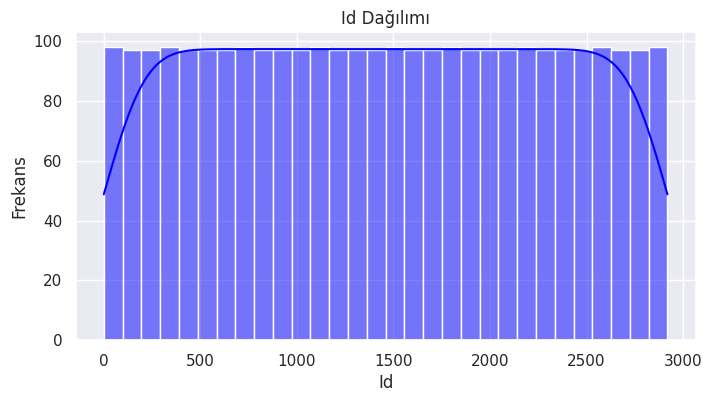

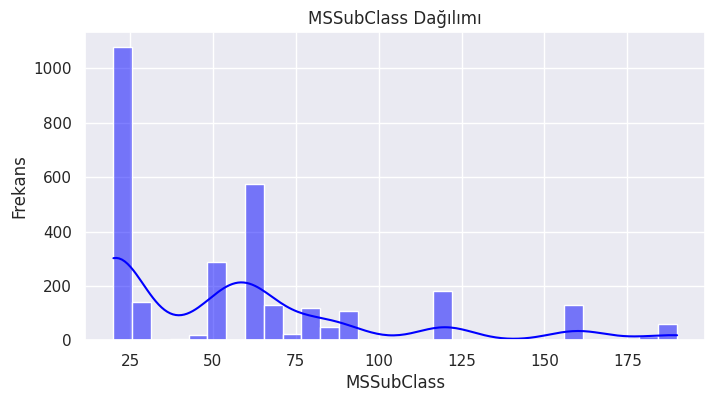

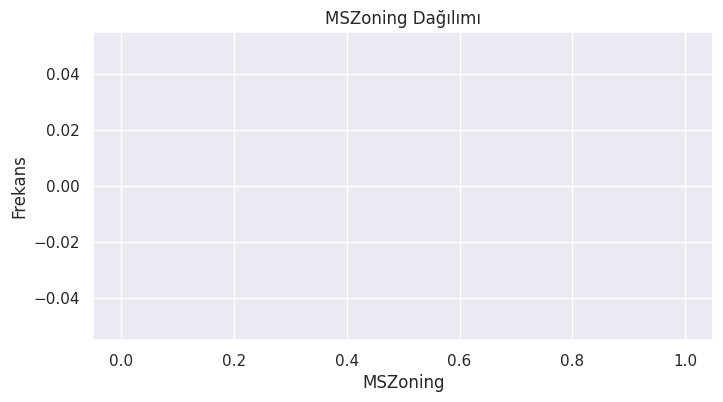

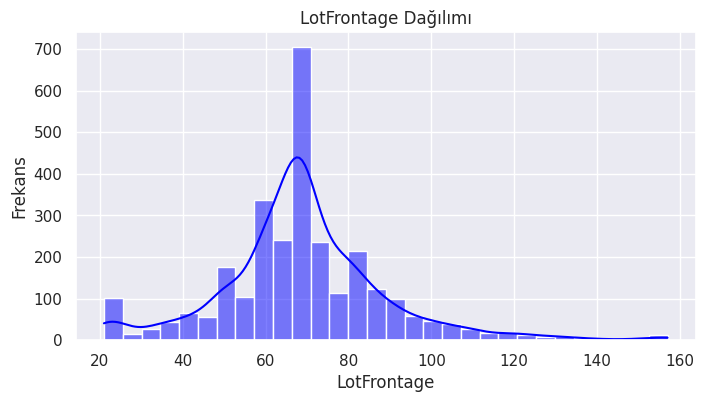

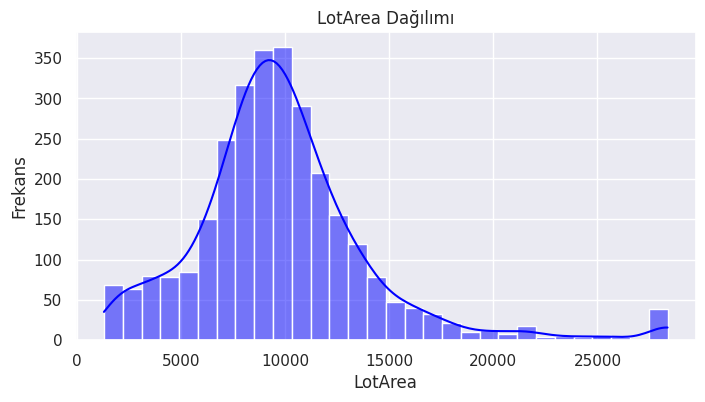

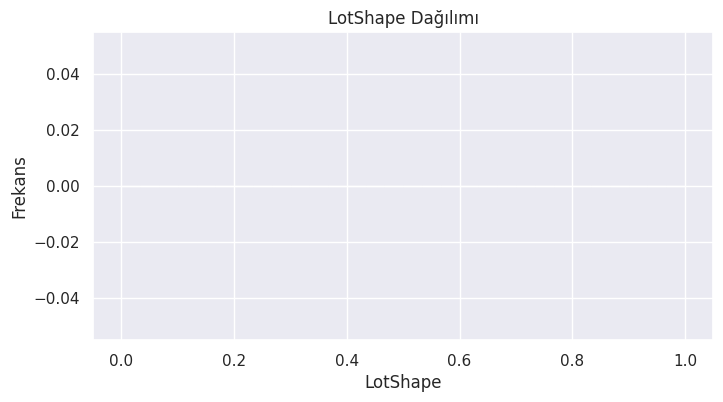

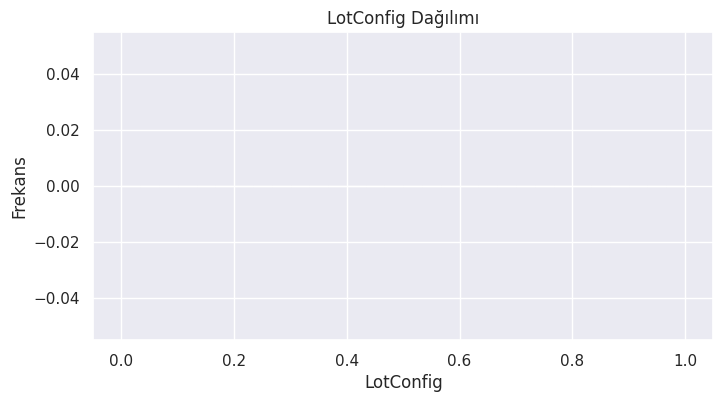

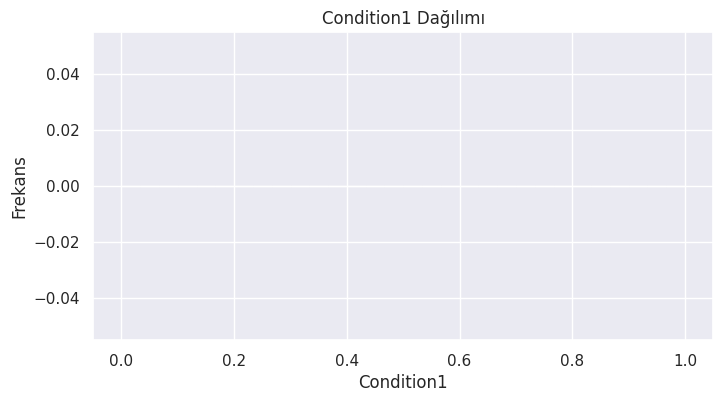

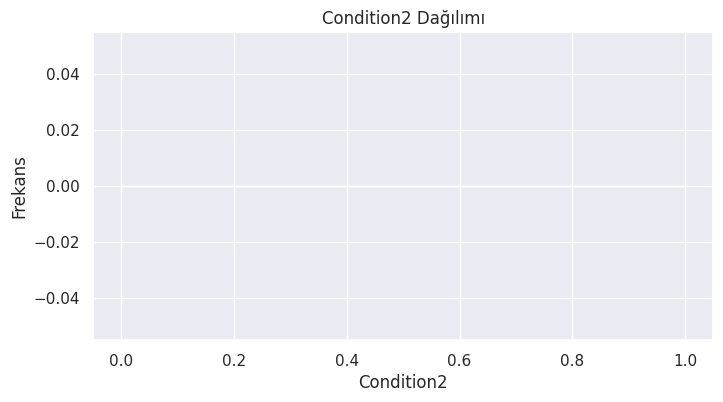

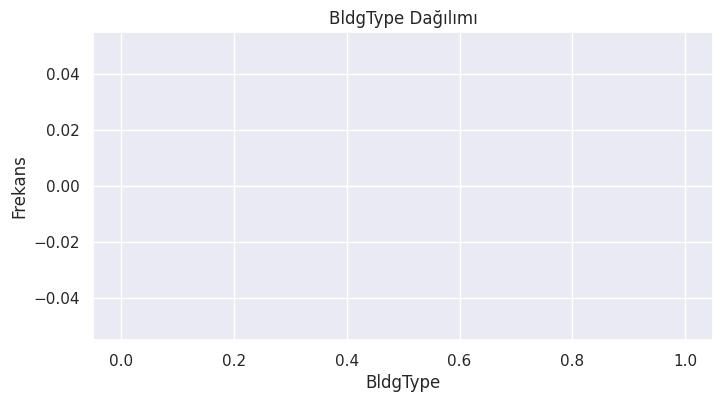

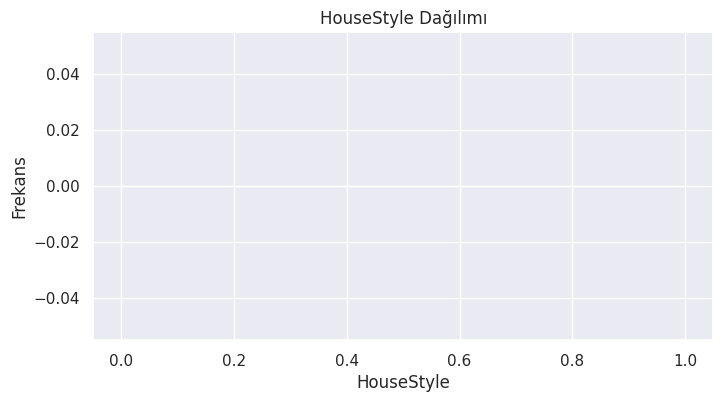

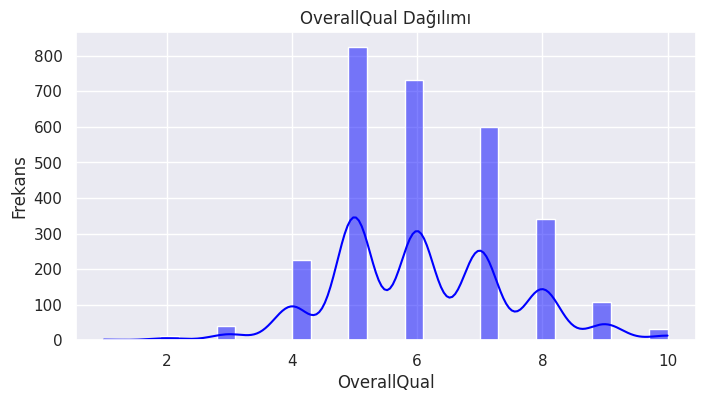

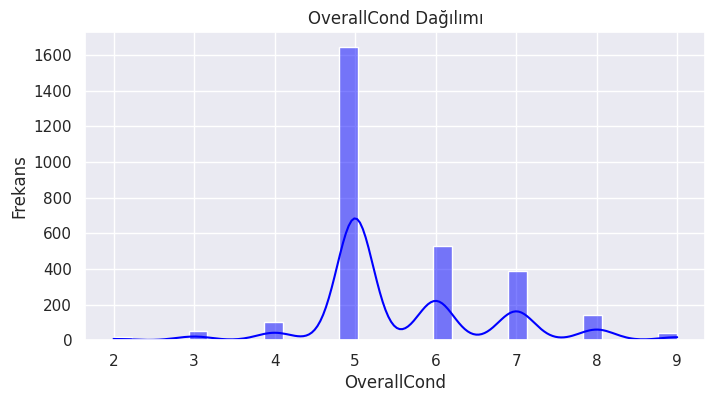

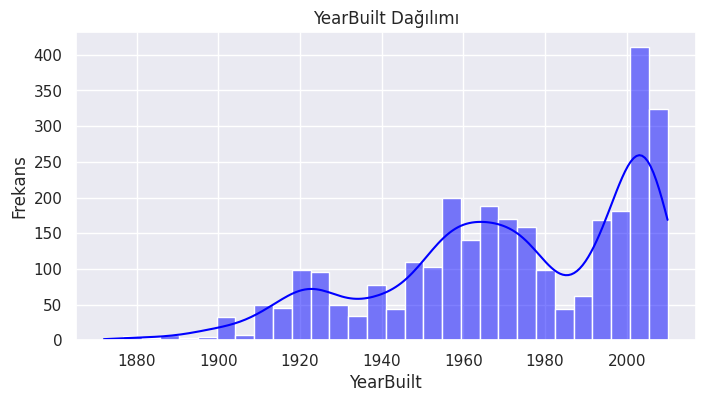

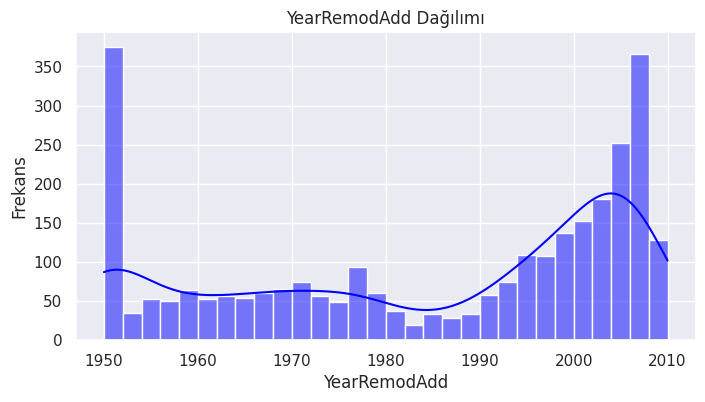

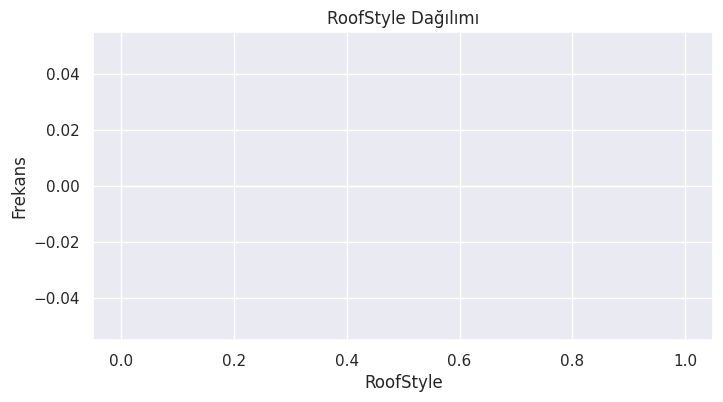

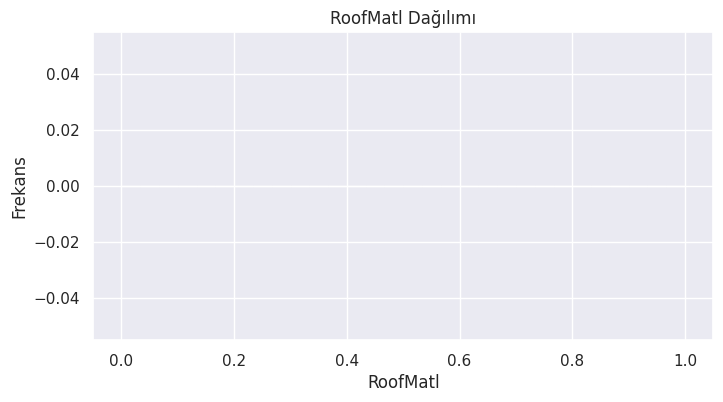

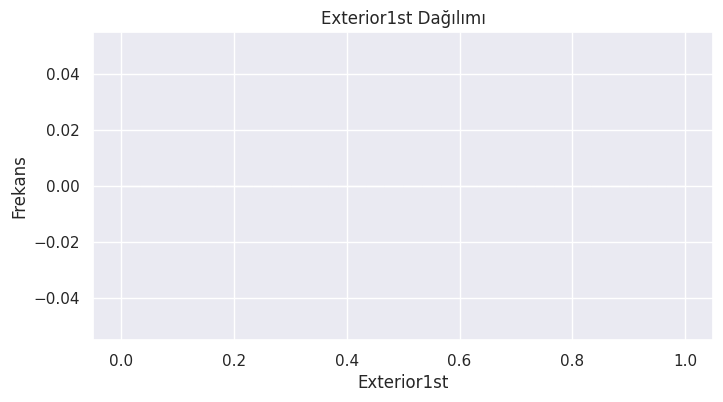

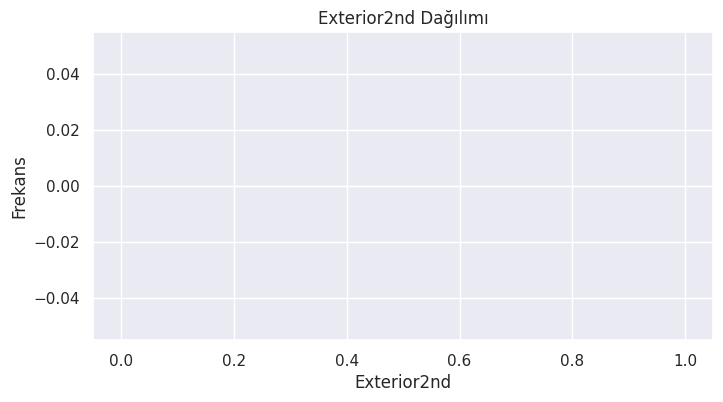

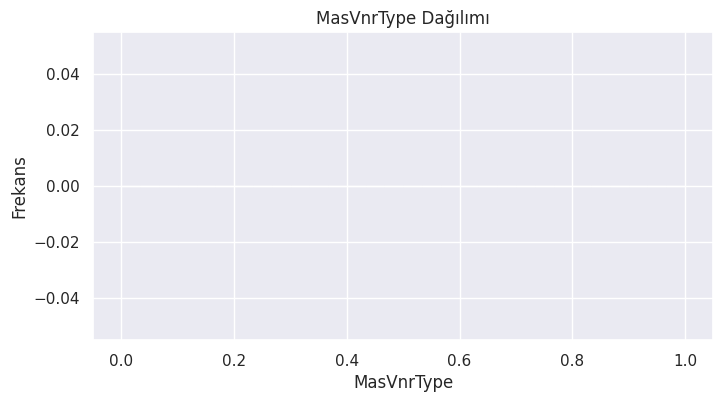

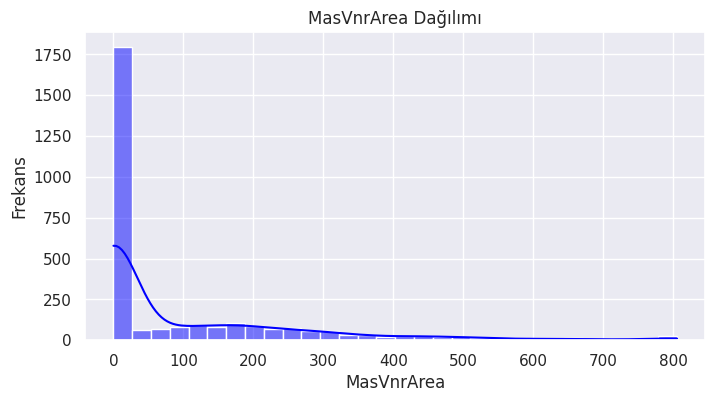

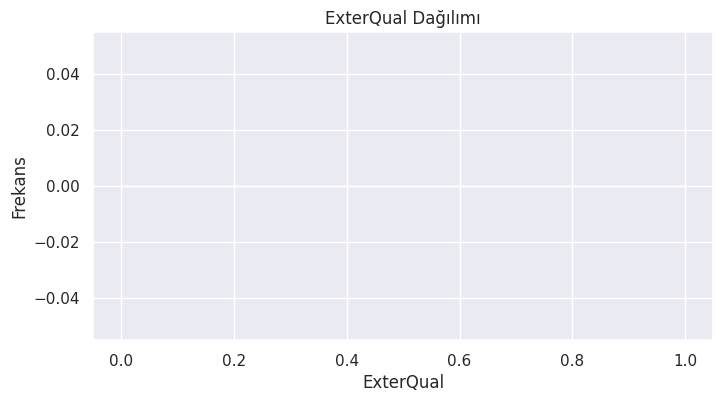

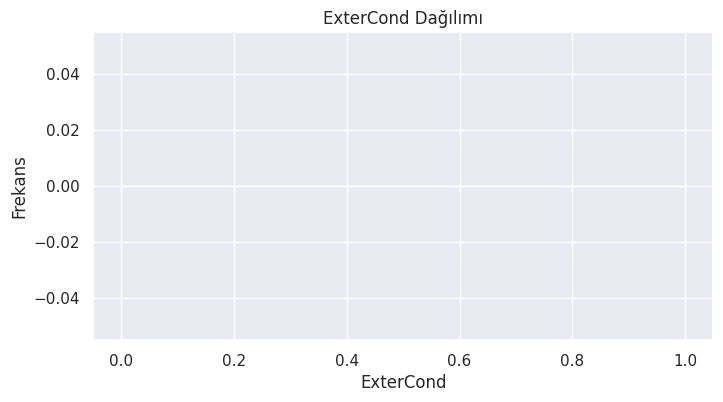

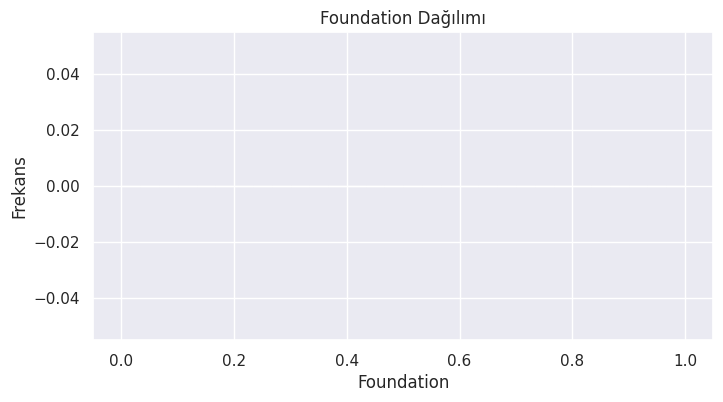

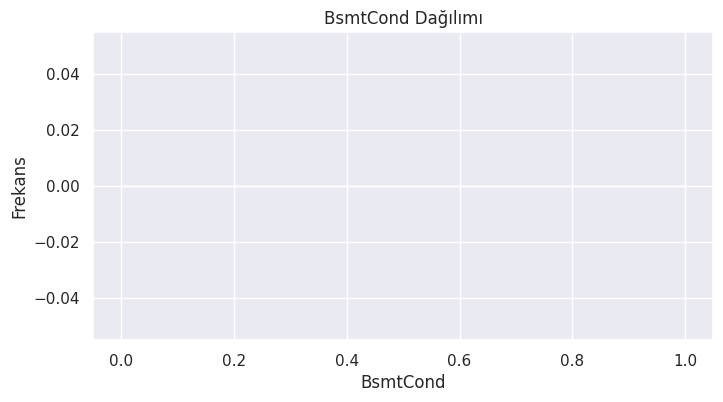

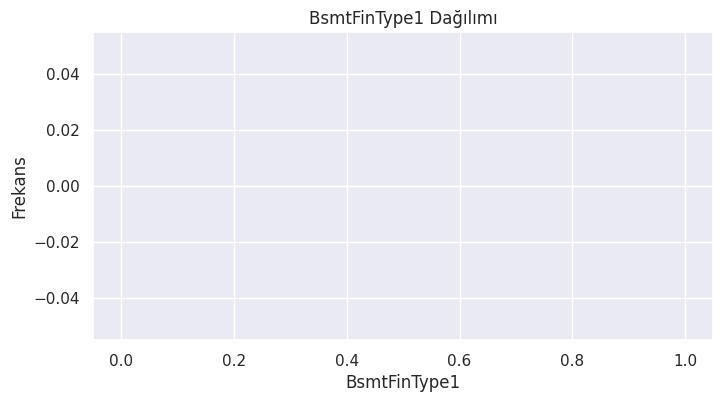

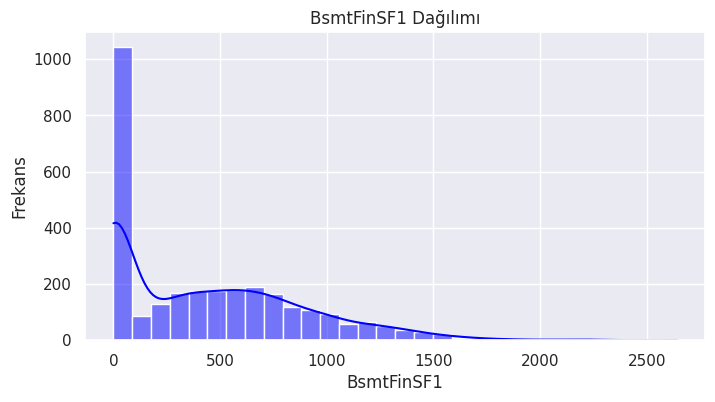

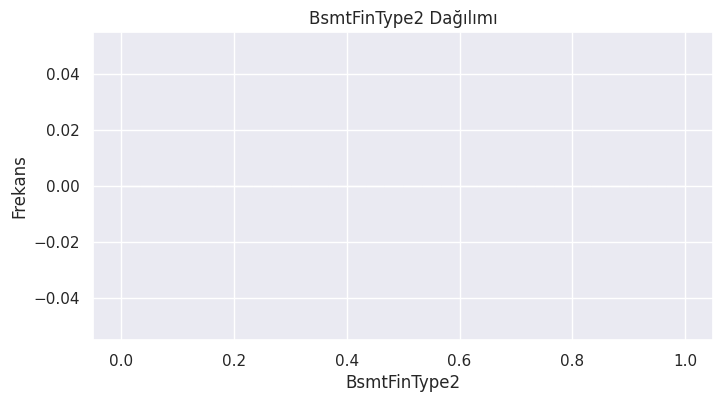

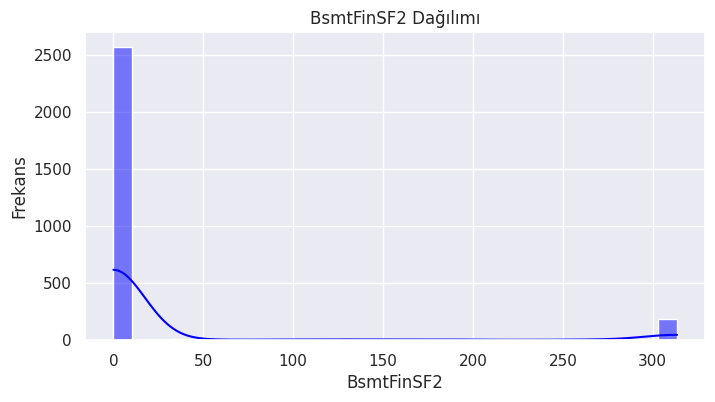

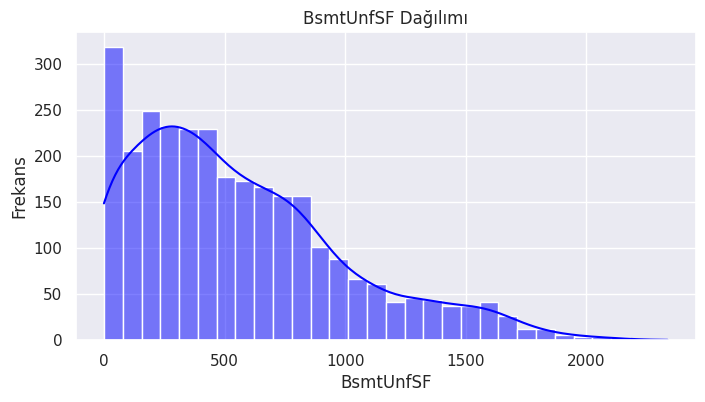

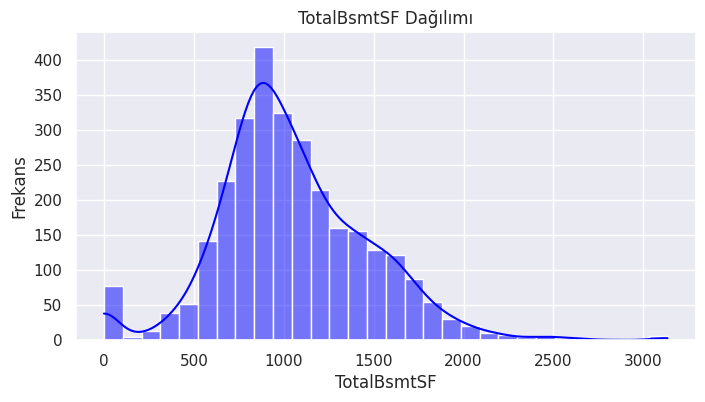

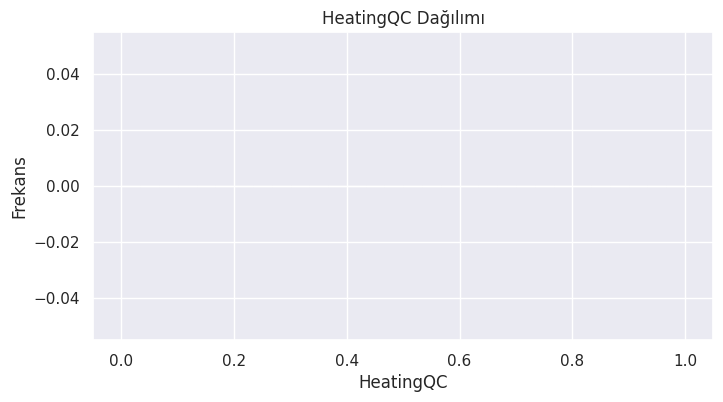

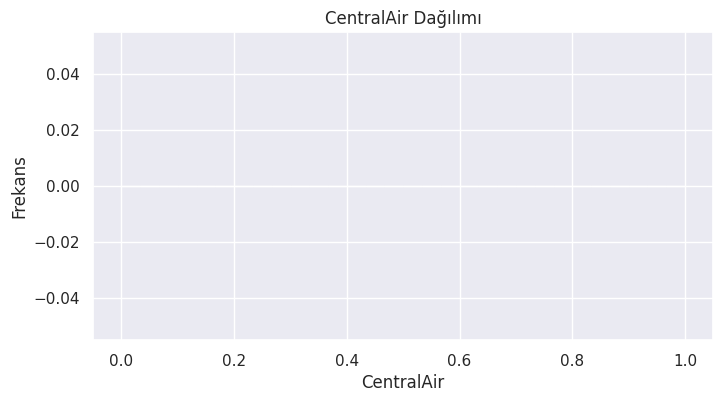

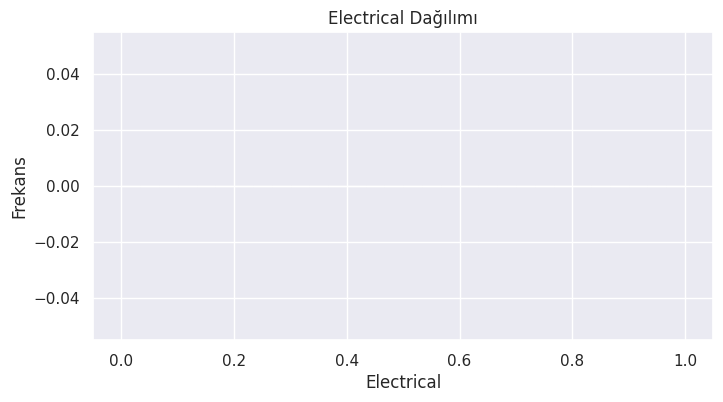

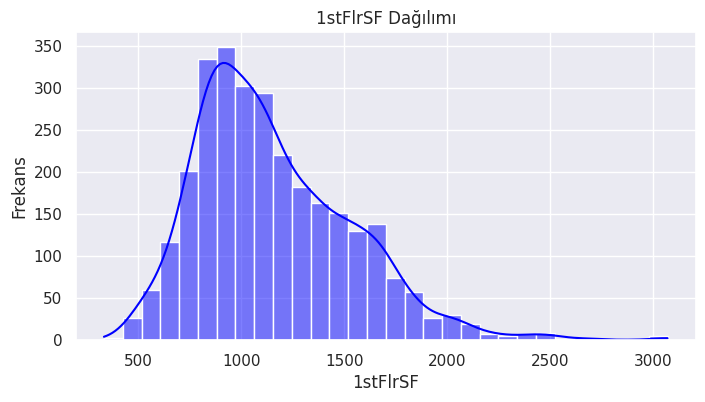

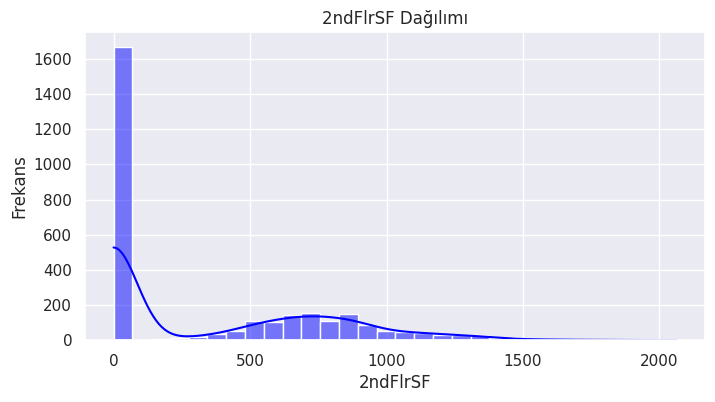

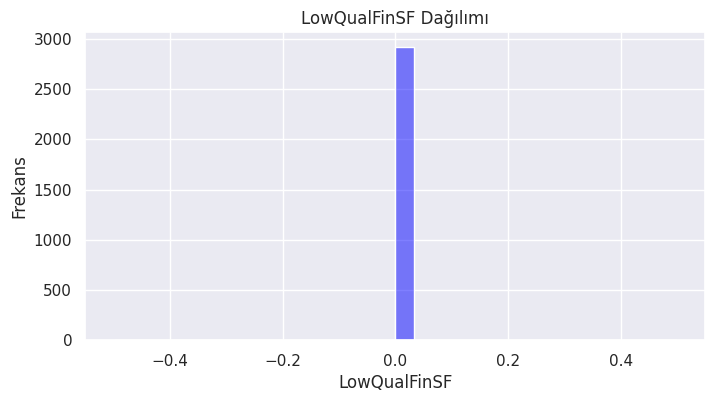

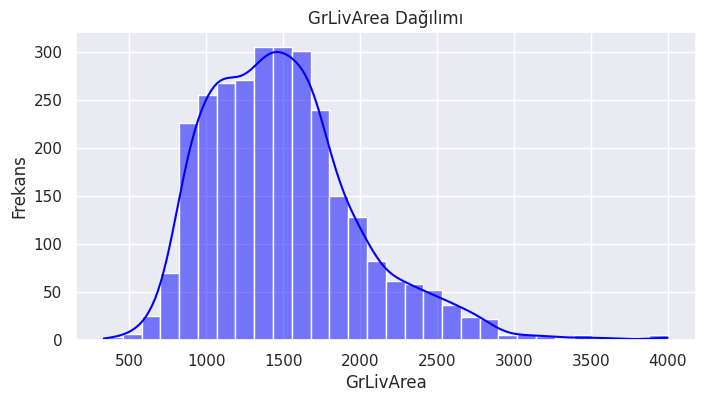

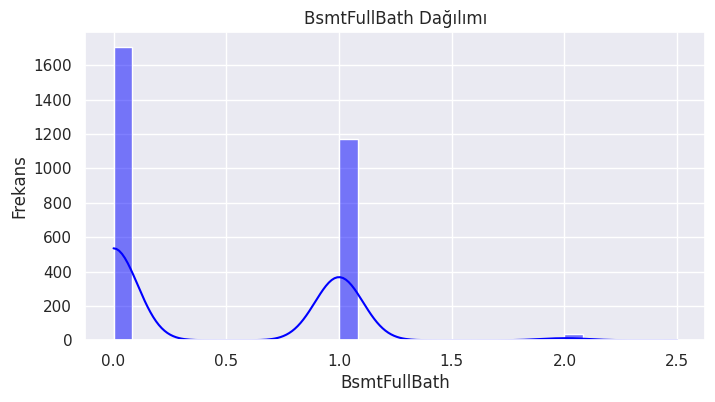

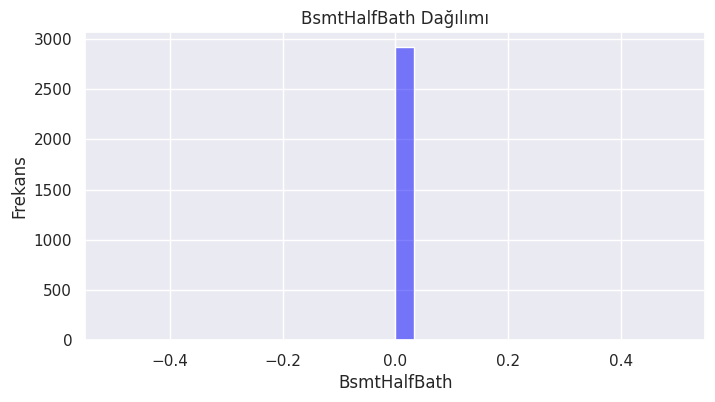

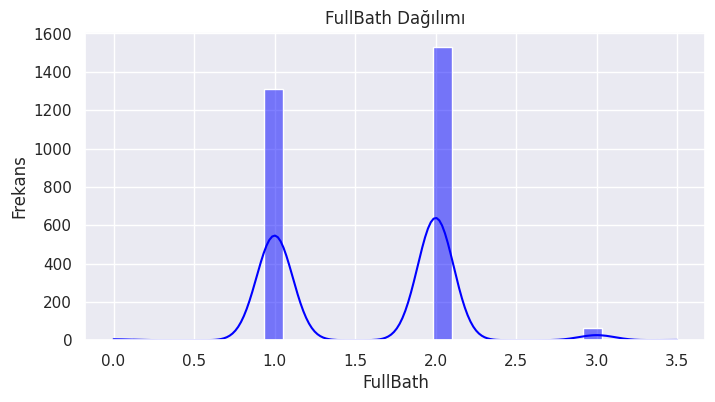

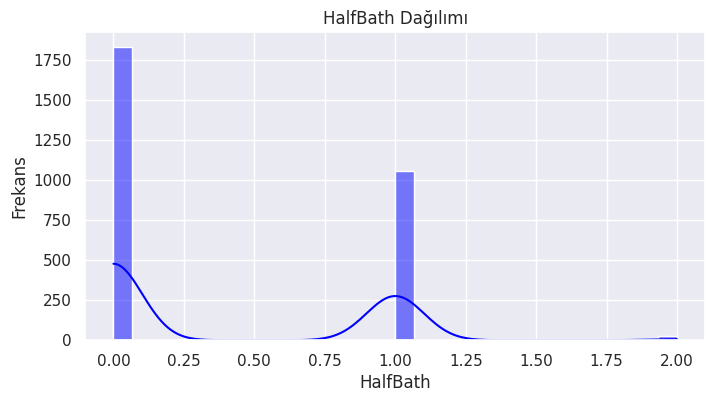

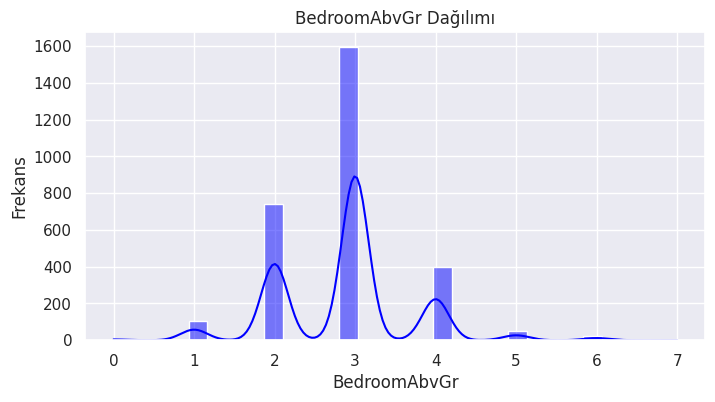

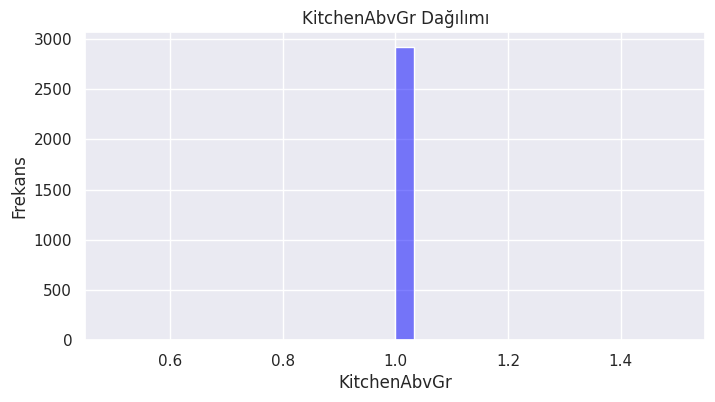

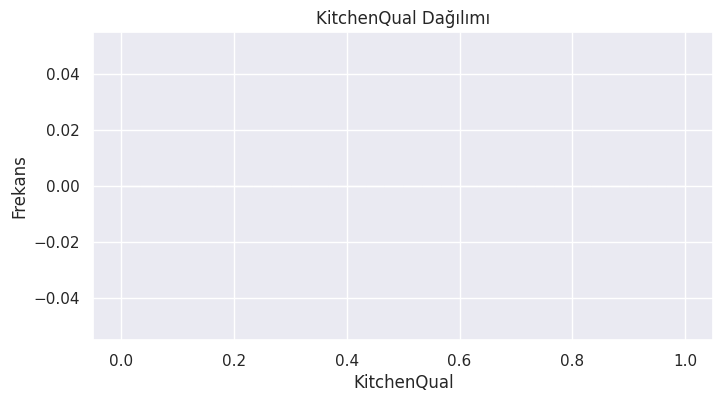

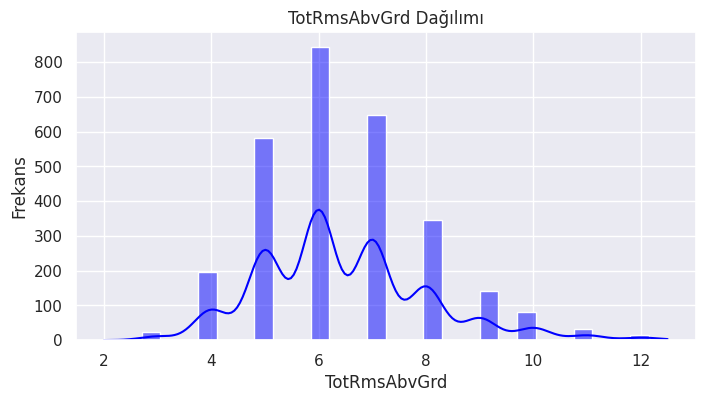

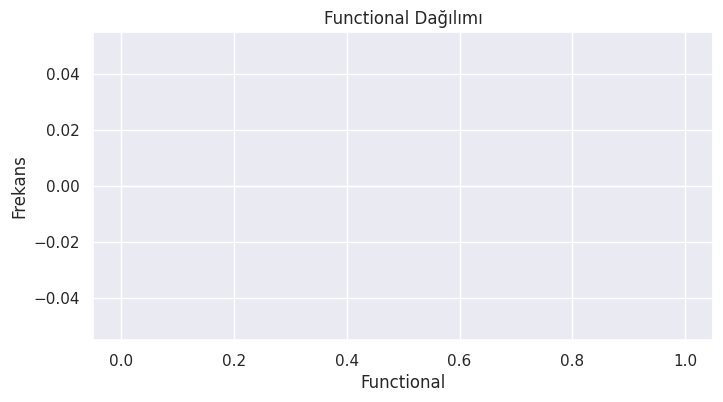

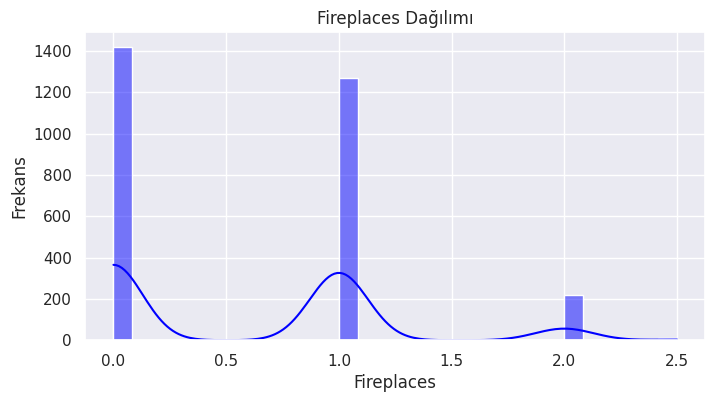

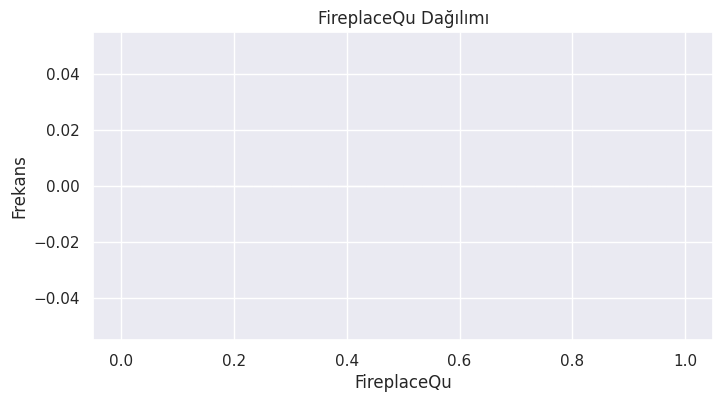

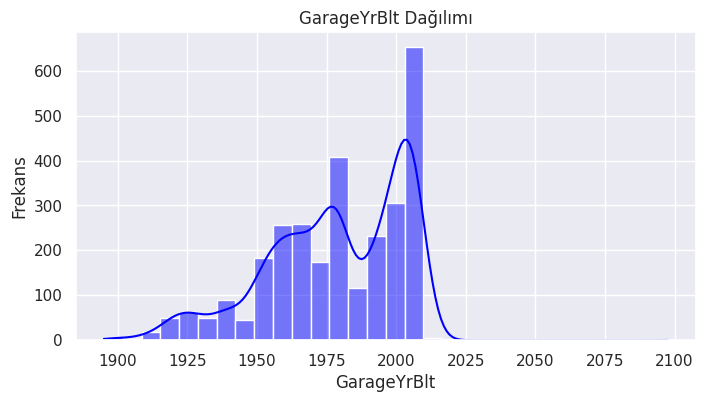

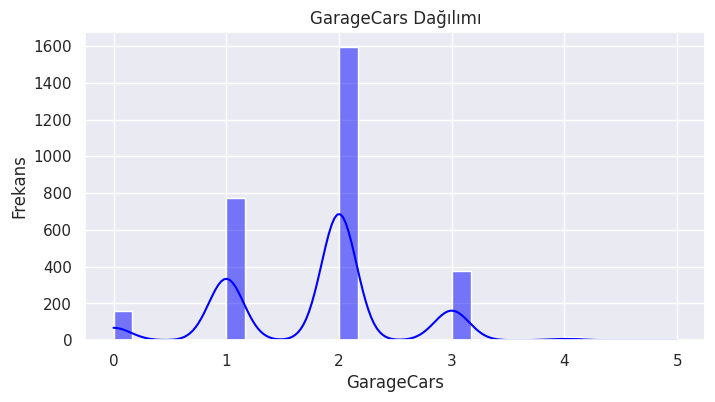

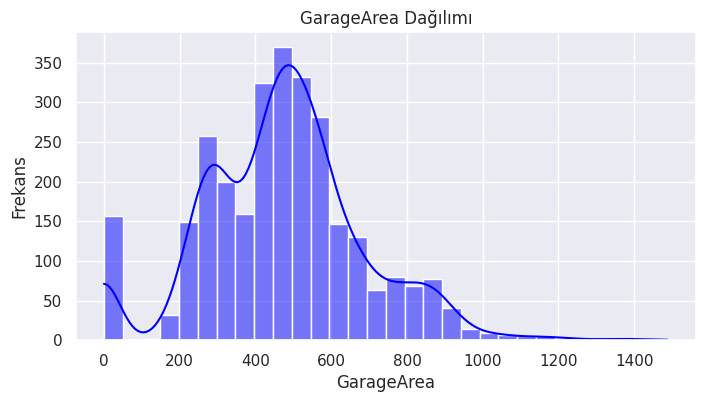

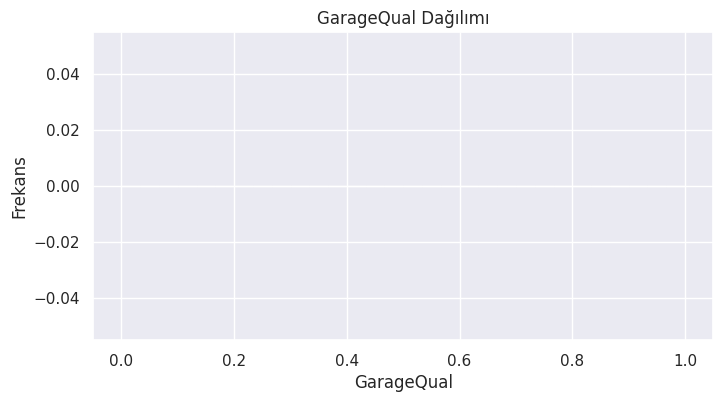

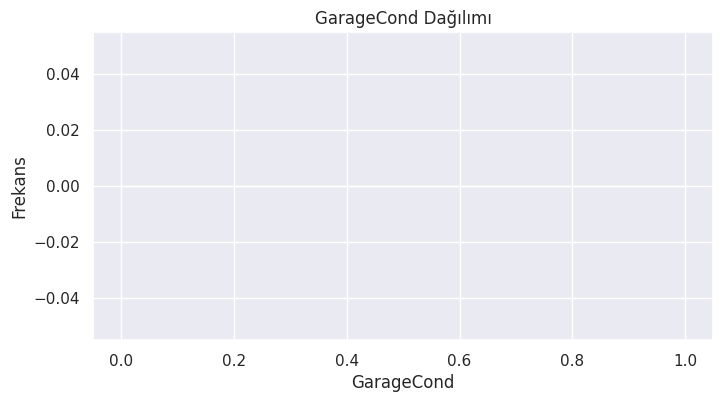

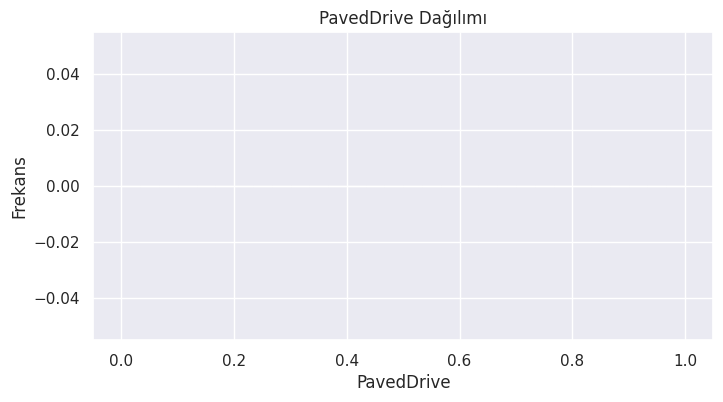

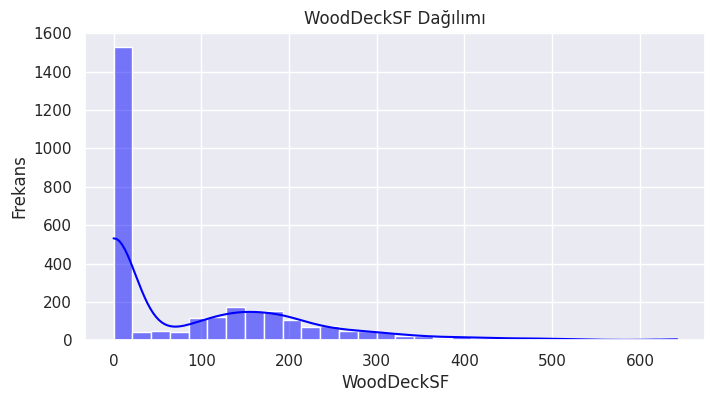

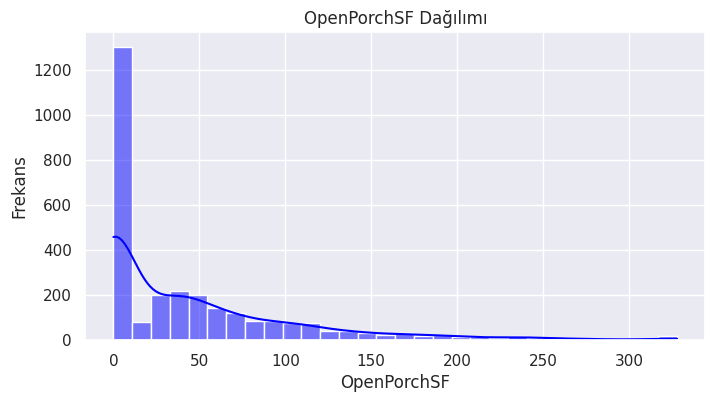

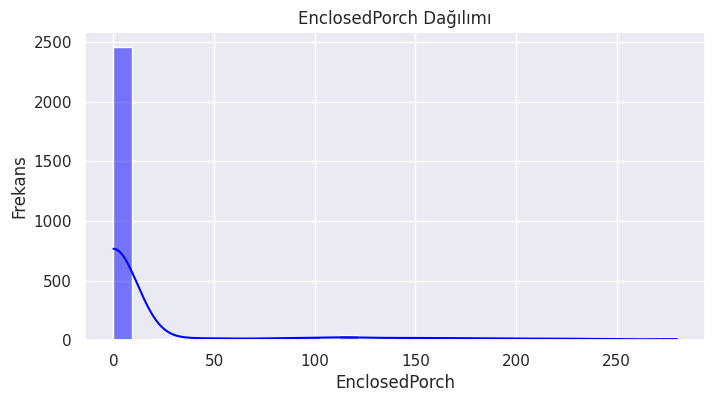

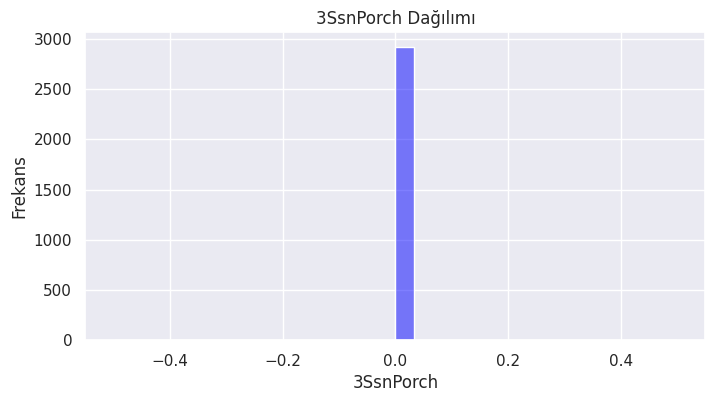

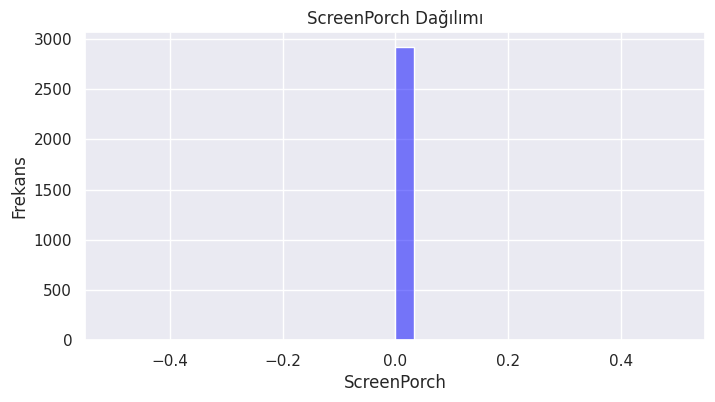

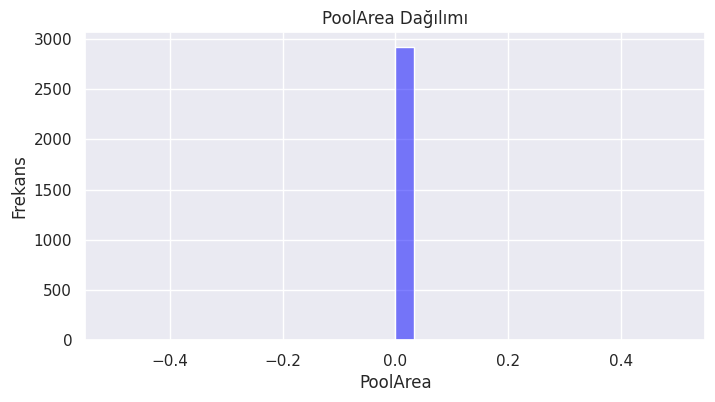

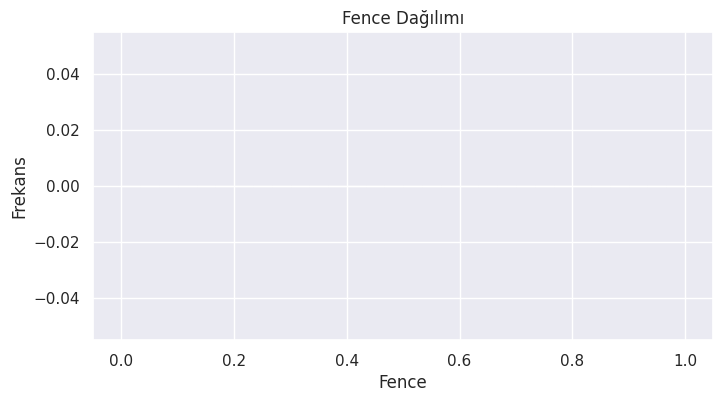

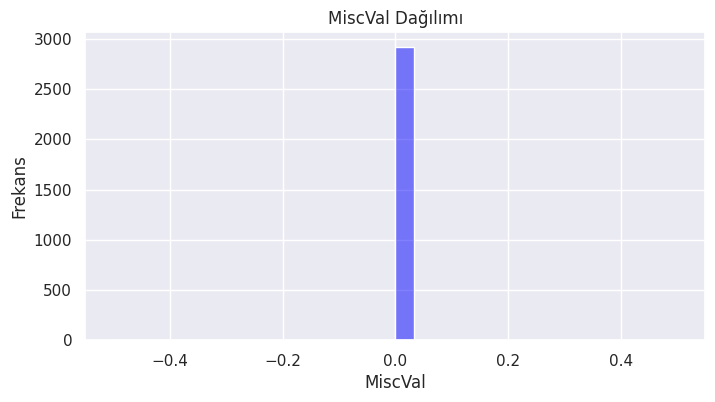

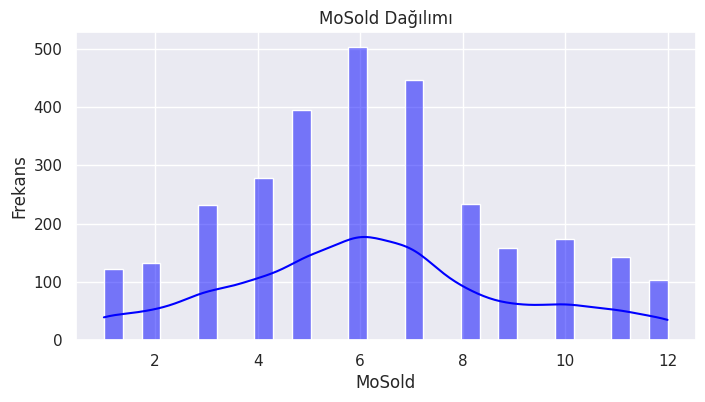

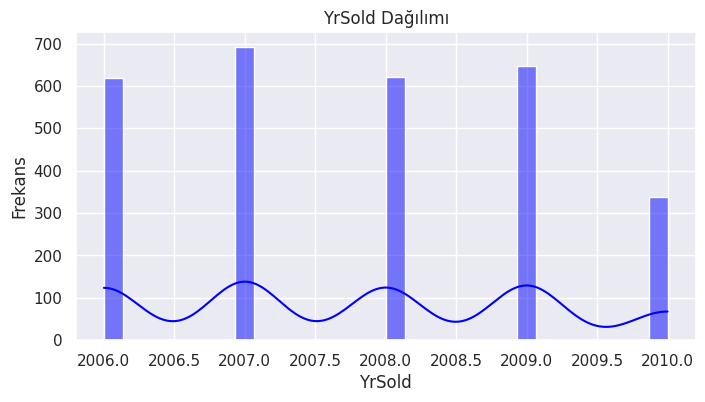

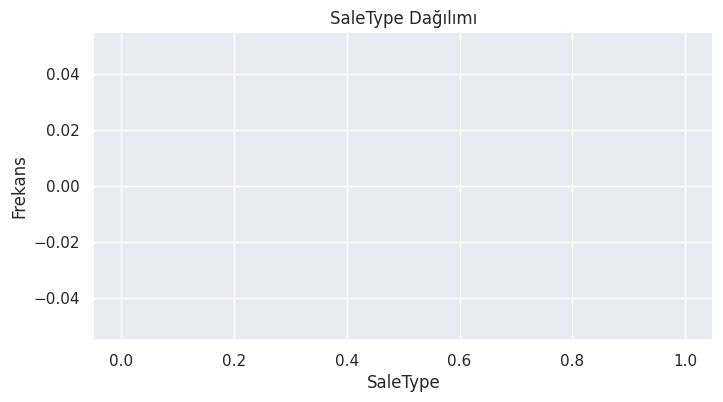

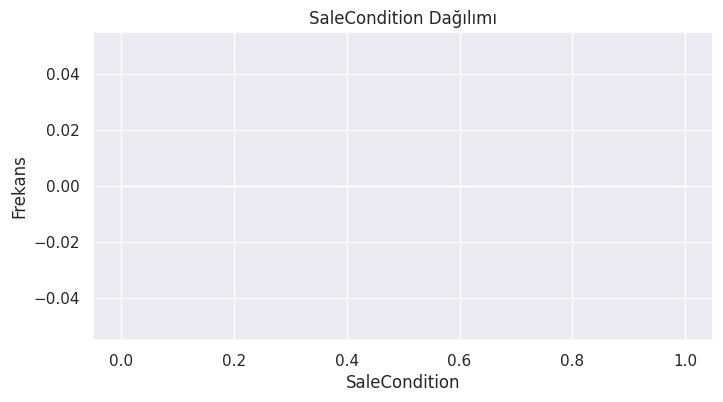

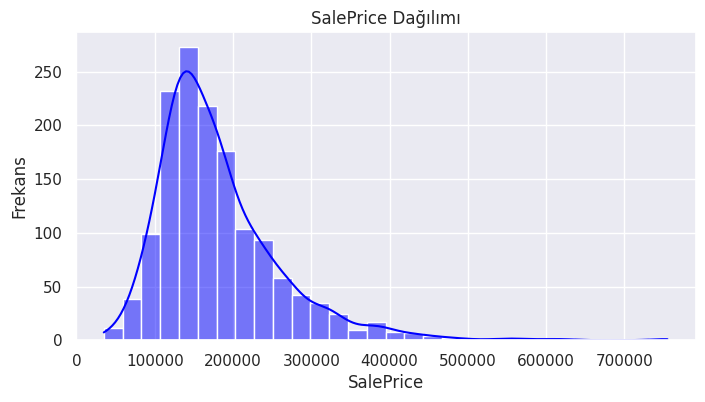

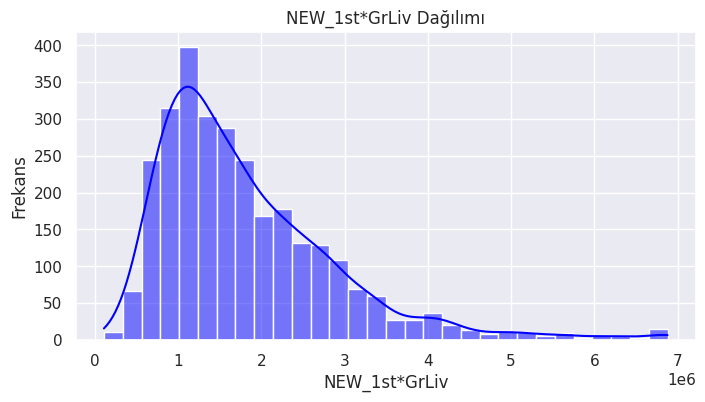

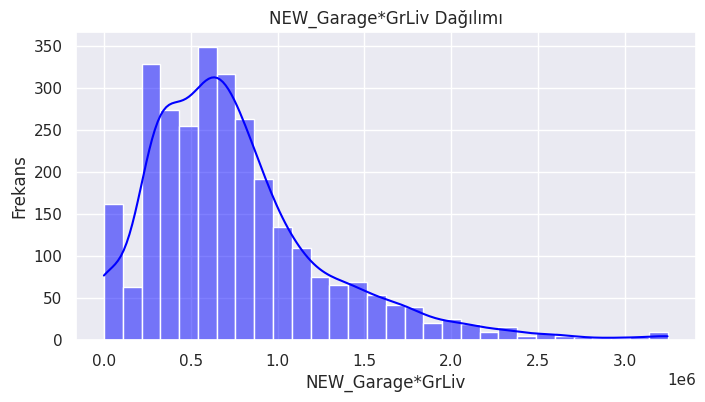

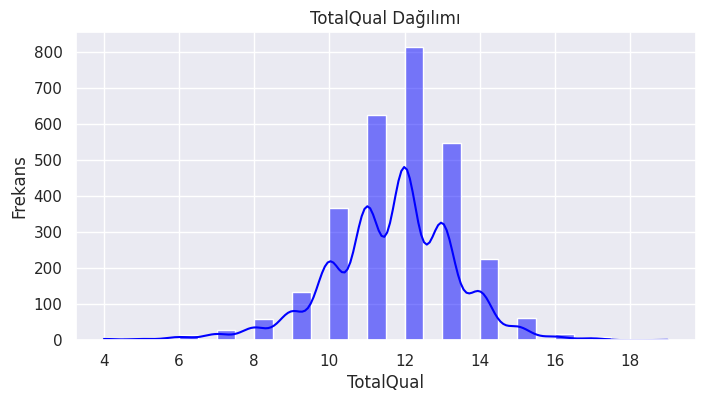

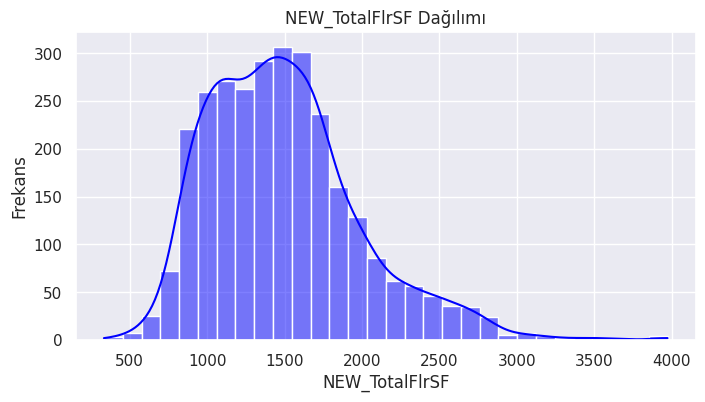

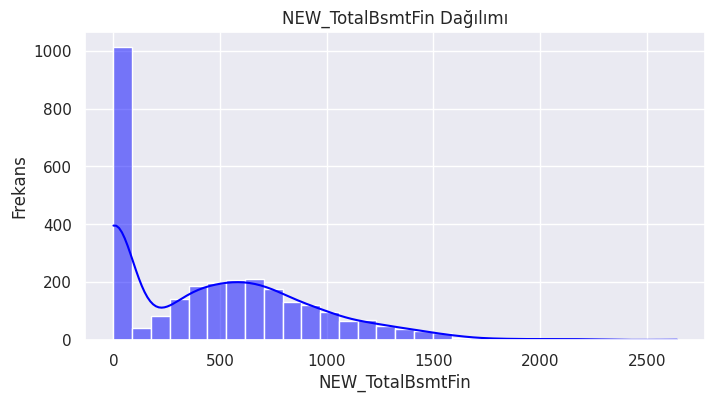

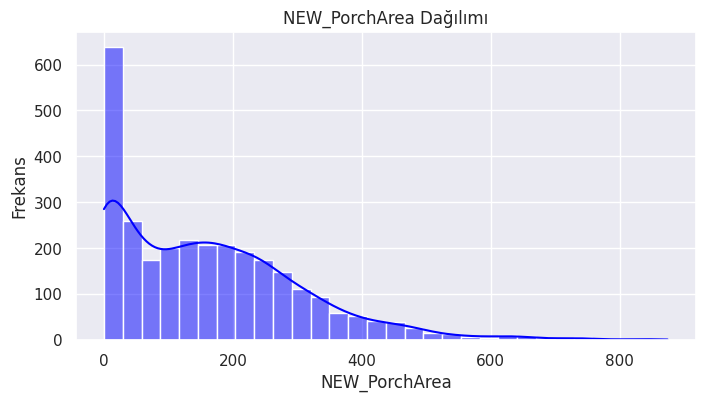

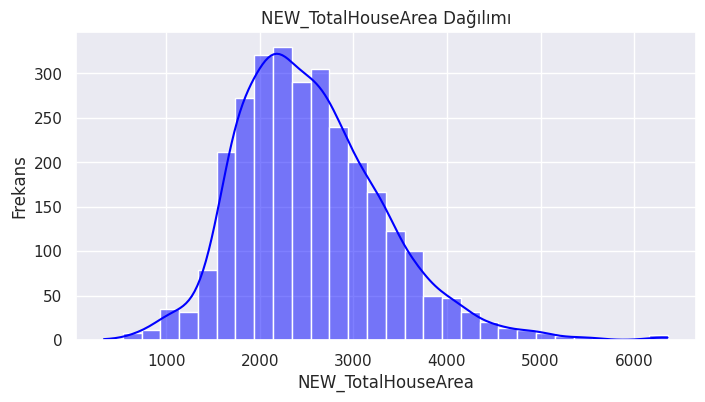

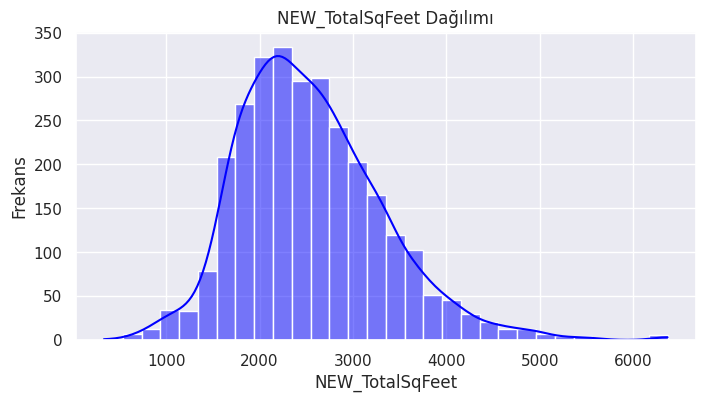

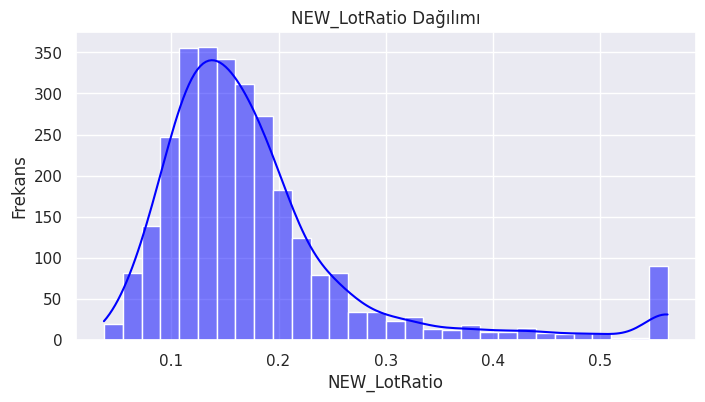

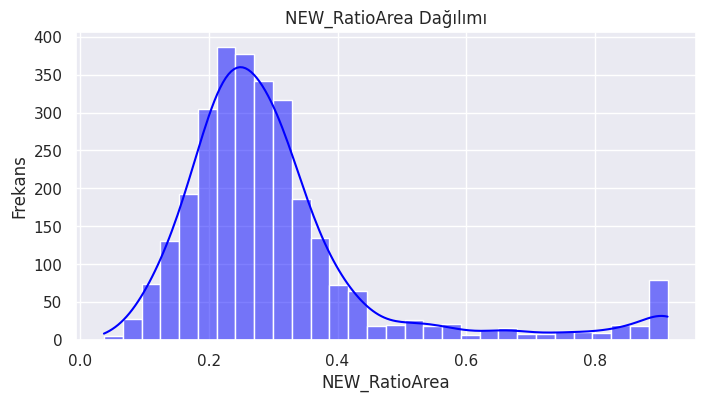

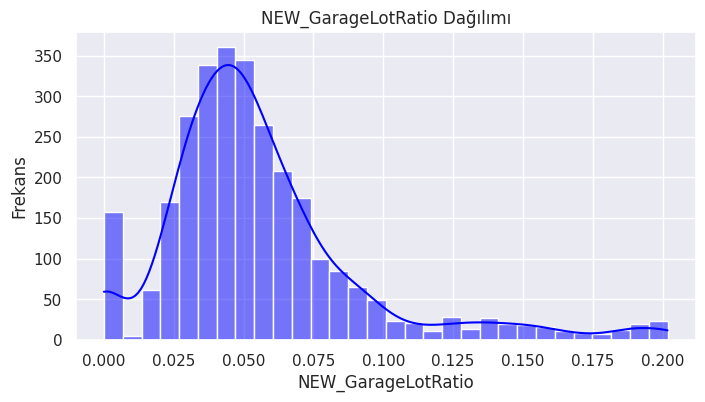

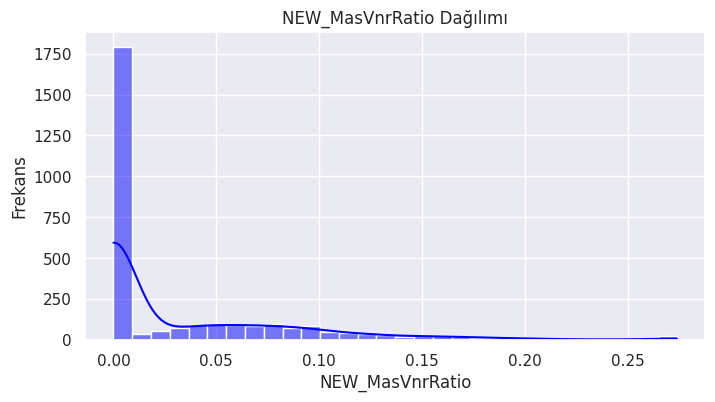

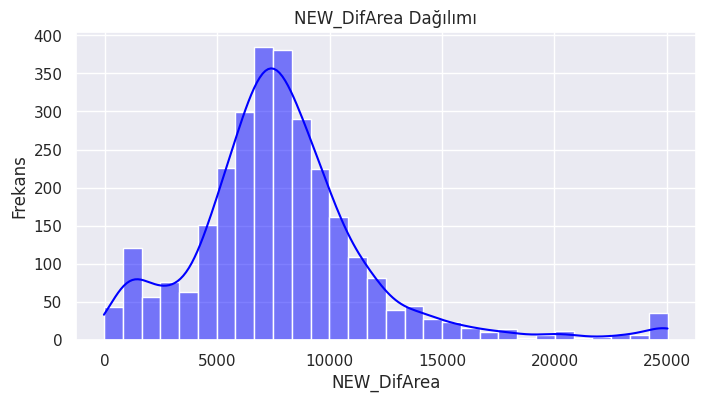

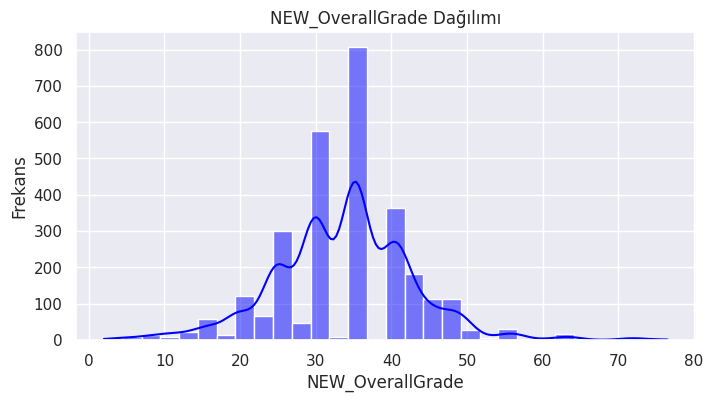

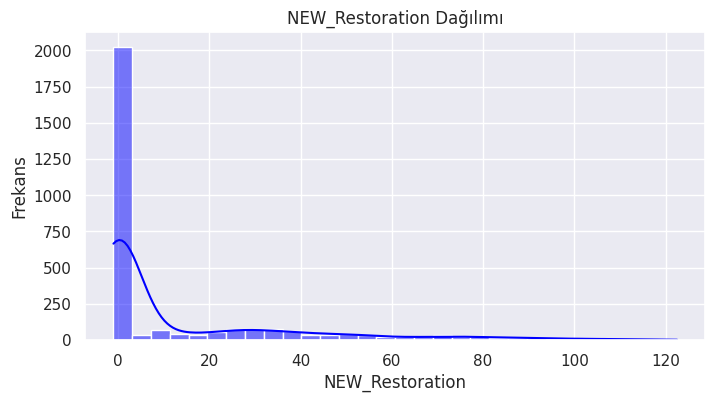

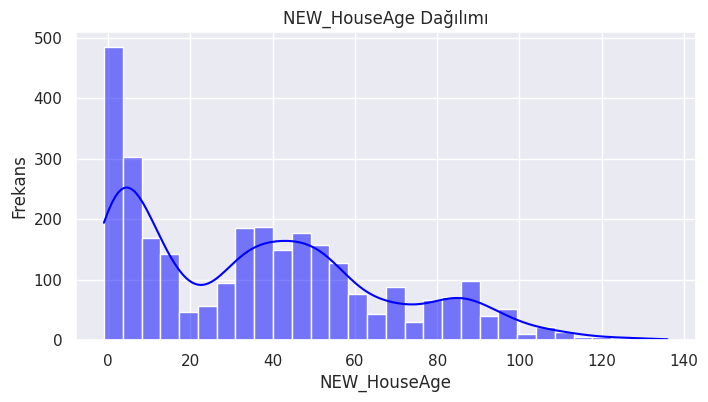

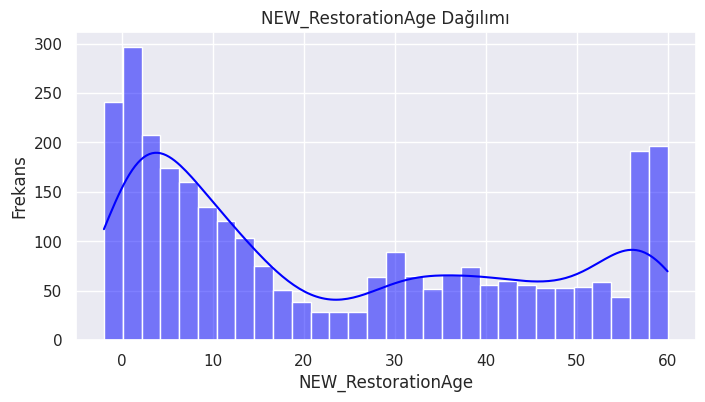

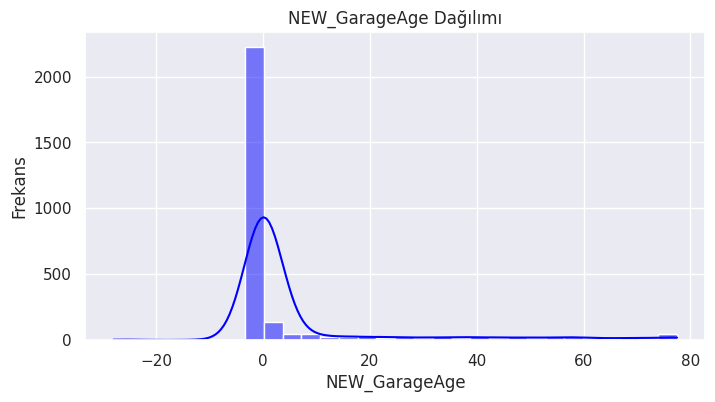

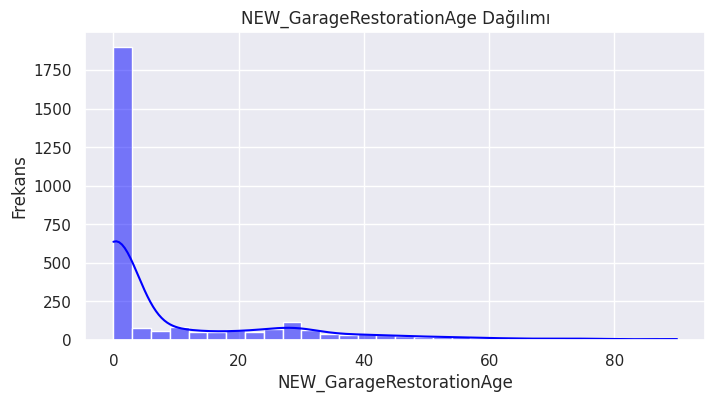

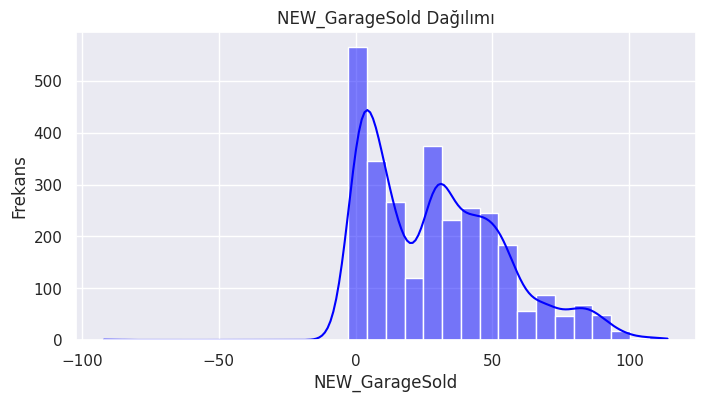

In [79]:
import matplotlib.pyplot as plt
import seaborn as sns

# Numerik ve kategorik değişkenlerin belirlenmesi
cat_cols, cat_but_car, num_cols = grab_col_names(df)

# Numerik değişkenlerin dağılımı
for col in num_cols:  # 'num_cols' listesine göre döngü
    plt.figure(figsize=(8, 4))
    sns.histplot(df[col], kde=True, bins=30, color='blue')
    plt.title(f'{col} Dağılımı')  # Başlık, değişken adına göre düzenlenmiş
    plt.xlabel(col)  # X etiketi
    plt.ylabel('Frekans')  # Y etiketi
    plt.show()

# Kategorik değişkenlerin dağılımı
for col in cat_cols:  # 'cat_cols' listesine göre döngü
    plt.figure(figsize=(8, 4))
    sns.countplot(data=df, x=col, palette='viridis', order=df[col].value_counts().index)
    plt.title(f'{col} Frekansı')  # Başlık, değişken adına göre düzenlenmiş
    plt.xlabel(col)  # X etiketi
    plt.ylabel('Frekans')  # Y etiketi
    plt.xticks(rotation=45)  # Eğer kategoriler çoksa döndür
    plt.show()


In [28]:
cat_cols = df.select_dtypes(include=['object']).columns


In [29]:
for col in cat_cols:
    cat_summary(df, col)


In [30]:

def cat_summary(dataframe, col_name, plot=False):
    print(pd.DataFrame({col_name: dataframe[col_name].value_counts(),
                        "Ratio": 100 * dataframe[col_name].value_counts() / len(dataframe)}))

    if plot:
        sns.countplot(x=dataframe[col_name], data=dataframe)
        plt.show()


for col in cat_cols:
    cat_summary(df, col)


count   2919.000
mean    1460.000
std      842.787
min        1.000
5%       146.900
10%      292.800
20%      584.600
30%      876.400
40%     1168.200
50%     1460.000
60%     1751.800
70%     2043.600
80%     2335.400
90%     2627.200
95%     2773.100
99%     2889.820
max     2919.000
Name: Id, dtype: float64


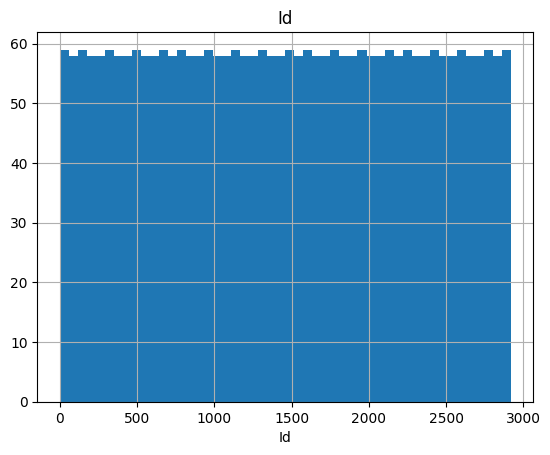

#####################################
count   2919.000
mean      57.138
std       42.518
min       20.000
5%        20.000
10%       20.000
20%       20.000
30%       20.000
40%       30.000
50%       50.000
60%       60.000
70%       60.000
80%       80.000
90%      120.000
95%      160.000
99%      190.000
max      190.000
Name: MSSubClass, dtype: float64


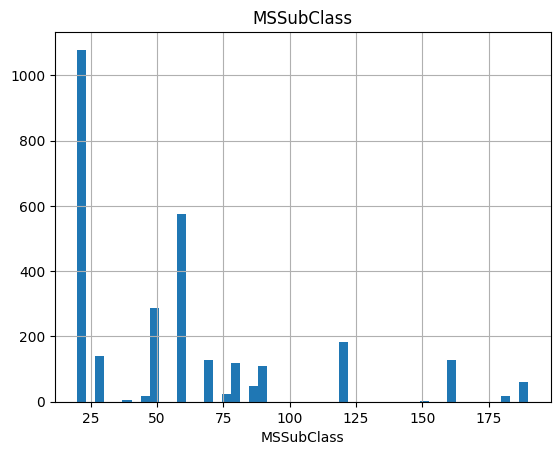

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: MSZoning, dtype: float64


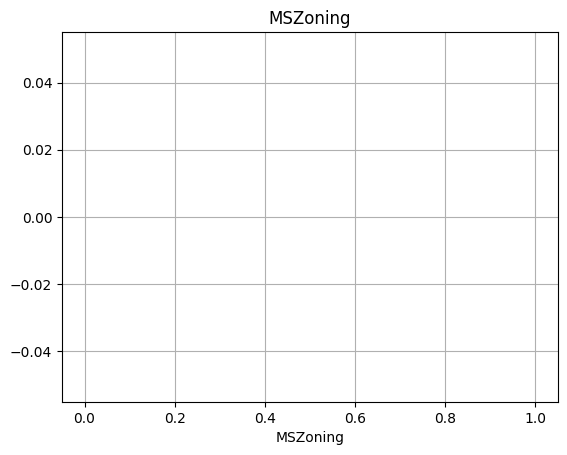

#####################################
count   2433.000
mean      69.306
std       23.345
min       21.000
5%        32.000
10%       43.000
20%       53.000
30%       60.000
40%       63.000
50%       68.000
60%       73.000
70%       78.000
80%       84.000
90%       95.000
95%      107.000
99%      135.680
max      313.000
Name: LotFrontage, dtype: float64


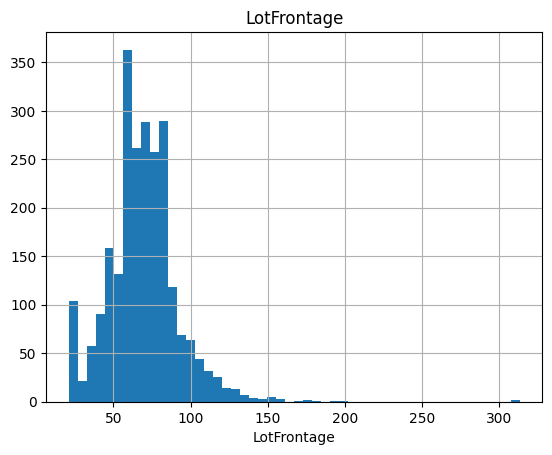

#####################################
count     2919.000
mean     10168.114
std       7886.996
min       1300.000
5%        3182.000
10%       4922.400
20%       7007.600
30%       7960.400
40%       8741.000
50%       9453.000
60%      10151.600
70%      11001.200
80%      12203.800
90%      14300.600
95%      17142.900
99%      33038.640
max     215245.000
Name: LotArea, dtype: float64


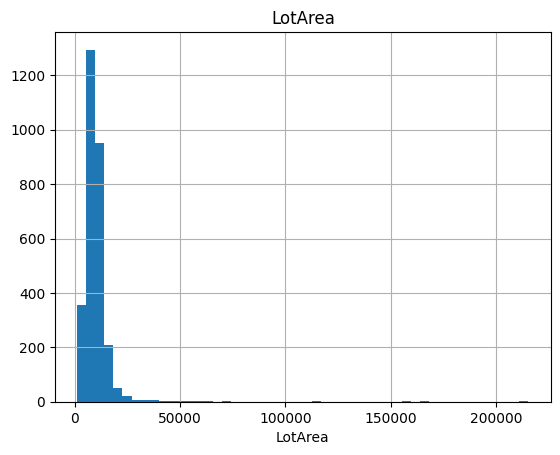

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Street, dtype: float64


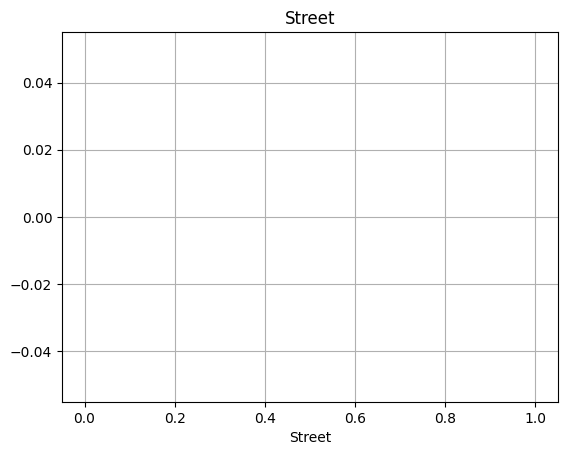

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Alley, dtype: float64


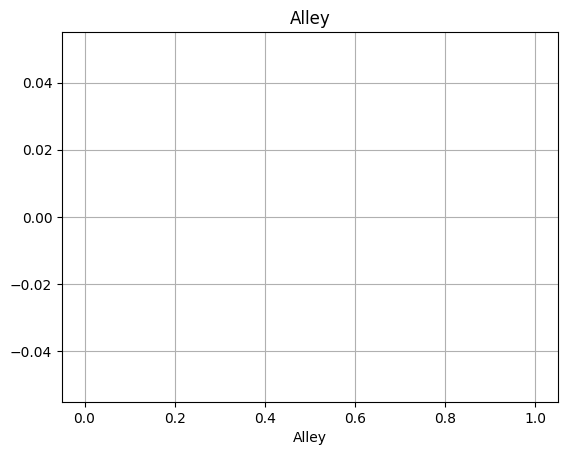

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: LotShape, dtype: float64


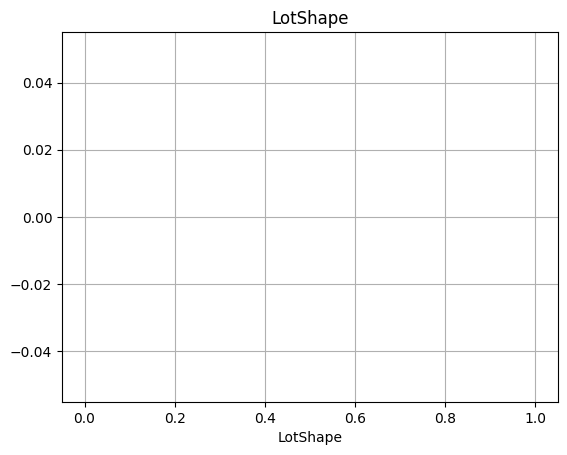

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: LandContour, dtype: float64


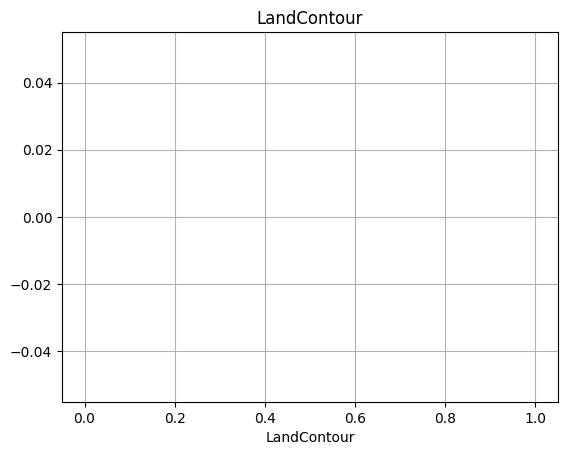

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Utilities, dtype: float64


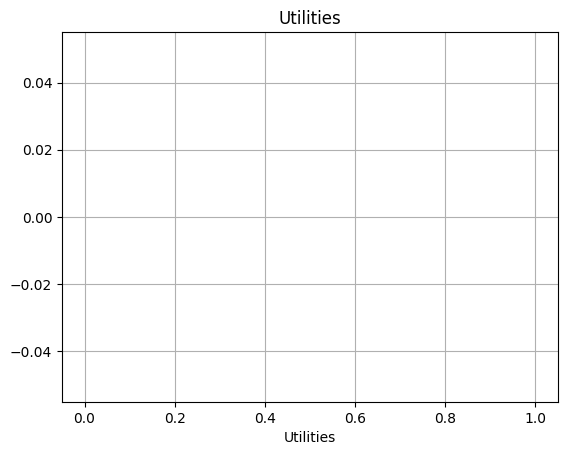

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: LotConfig, dtype: float64


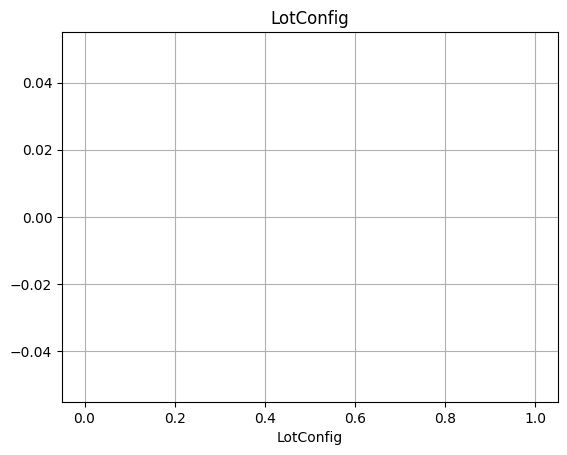

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: LandSlope, dtype: float64


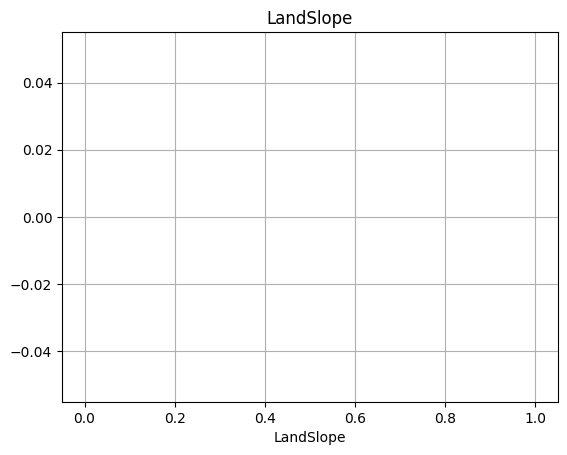

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Neighborhood, dtype: float64


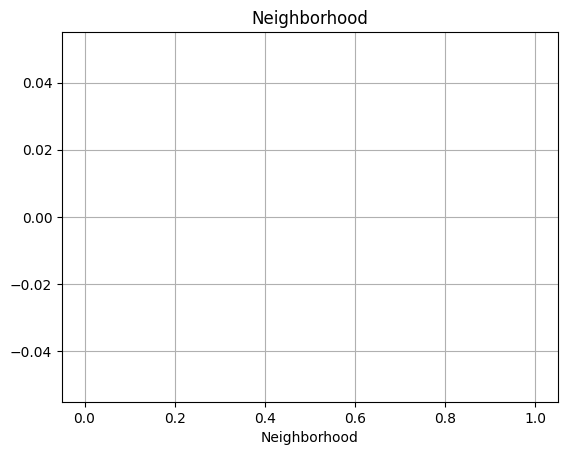

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Condition1, dtype: float64


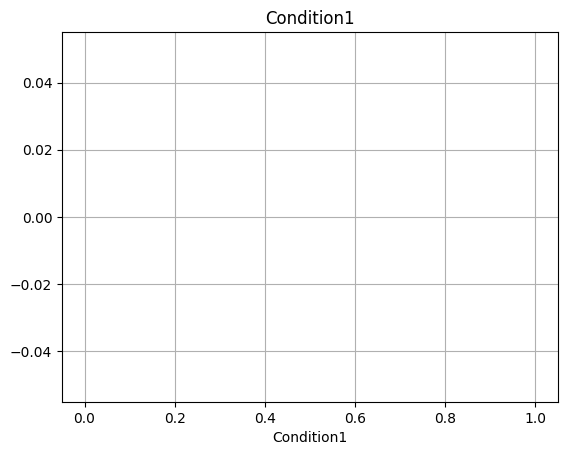

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Condition2, dtype: float64


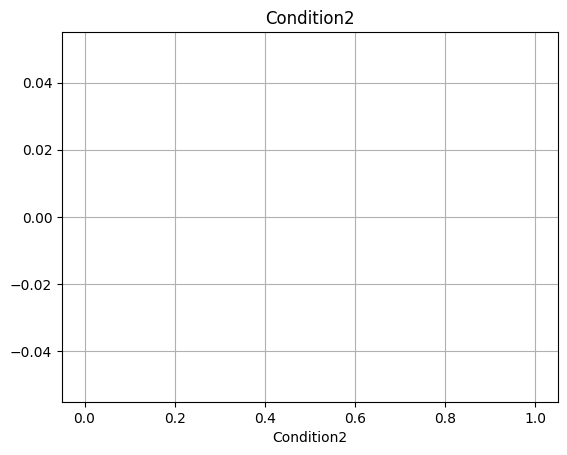

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: BldgType, dtype: float64


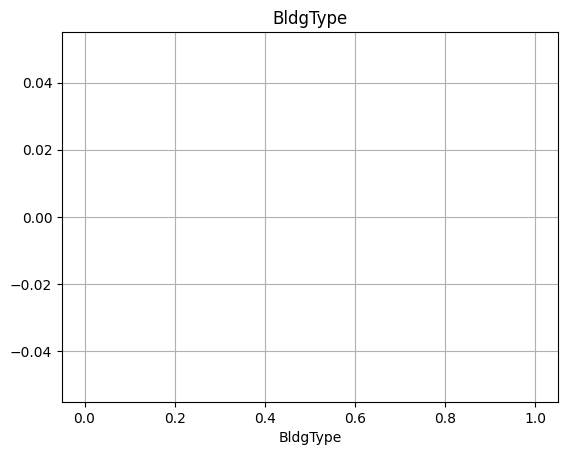

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: HouseStyle, dtype: float64


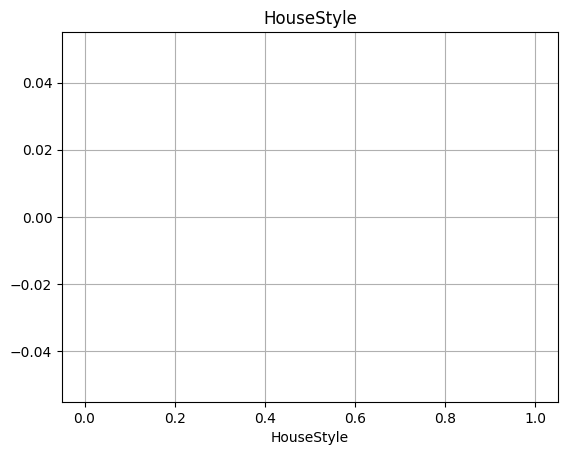

#####################################
count   2919.000
mean       6.089
std        1.410
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        6.000
50%        6.000
60%        6.000
70%        7.000
80%        7.000
90%        8.000
95%        8.000
99%       10.000
max       10.000
Name: OverallQual, dtype: float64


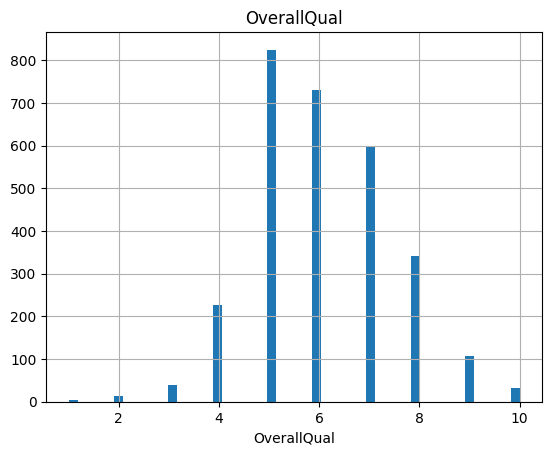

#####################################
count   2919.000
mean       5.565
std        1.113
min        1.000
5%         4.000
10%        5.000
20%        5.000
30%        5.000
40%        5.000
50%        5.000
60%        5.000
70%        6.000
80%        6.000
90%        7.000
95%        8.000
99%        9.000
max        9.000
Name: OverallCond, dtype: float64


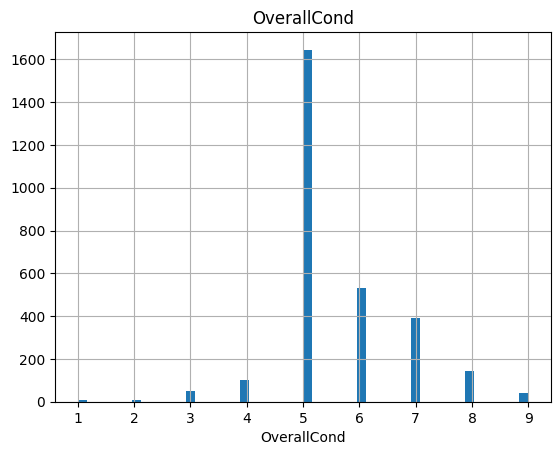

#####################################
count   2919.000
mean    1971.313
std       30.291
min     1872.000
5%      1915.000
10%     1924.000
20%     1947.000
30%     1957.000
40%     1965.000
50%     1973.000
60%     1984.000
70%     1998.000
80%     2003.000
90%     2006.000
95%     2007.000
99%     2008.000
max     2010.000
Name: YearBuilt, dtype: float64


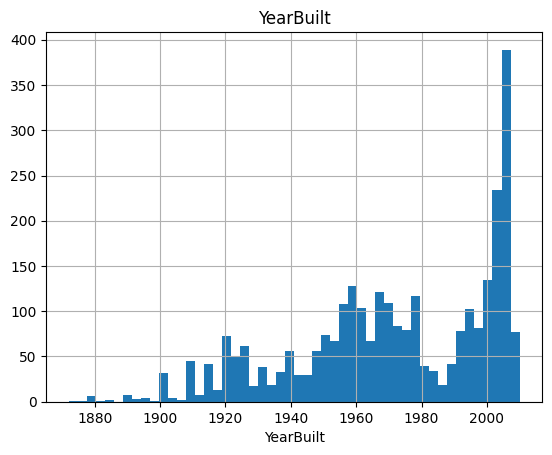

#####################################
count   2919.000
mean    1984.264
std       20.894
min     1950.000
5%      1950.000
10%     1950.000
20%     1960.000
30%     1970.000
40%     1978.000
50%     1993.000
60%     1998.000
70%     2002.000
80%     2005.000
90%     2006.200
95%     2007.000
99%     2009.000
max     2010.000
Name: YearRemodAdd, dtype: float64


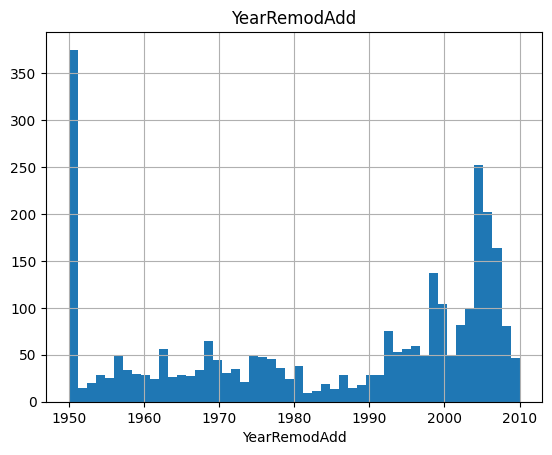

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: RoofStyle, dtype: float64


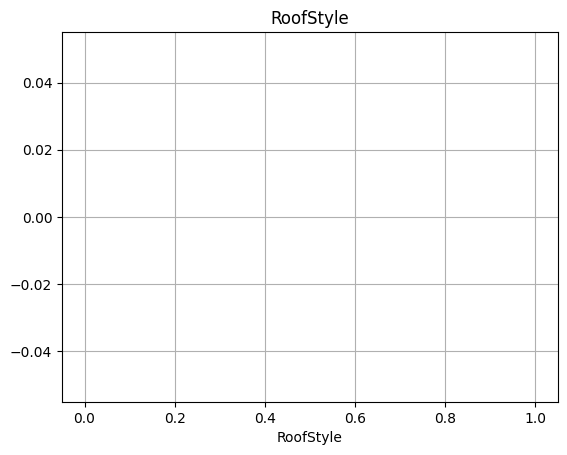

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: RoofMatl, dtype: float64


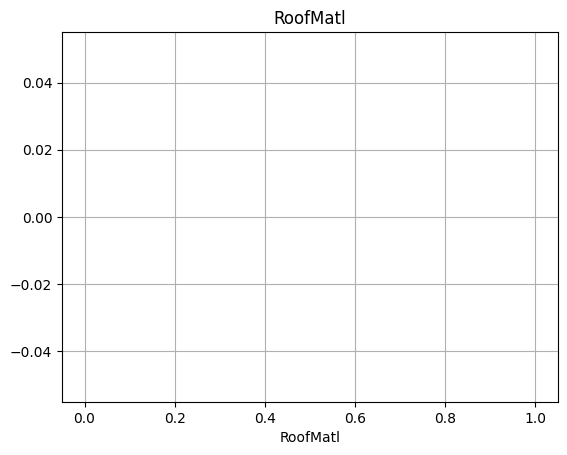

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Exterior1st, dtype: float64


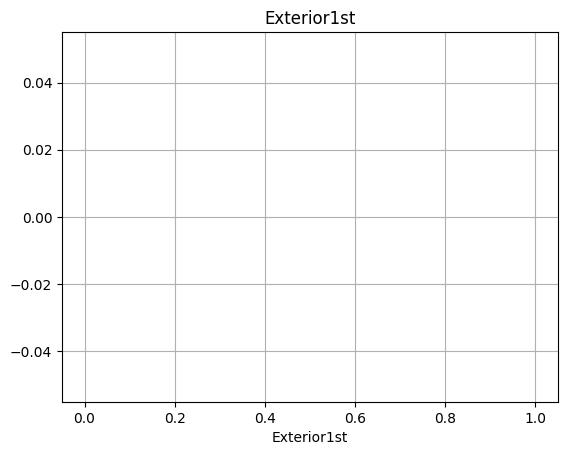

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Exterior2nd, dtype: float64


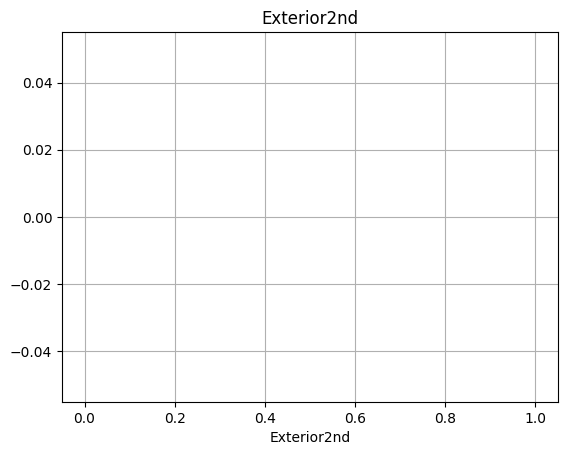

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: MasVnrType, dtype: float64


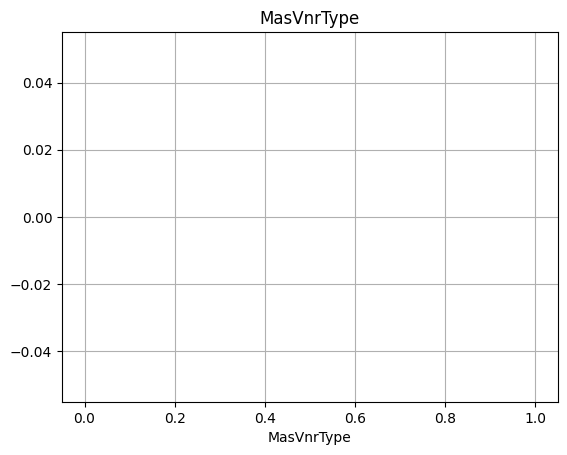

#####################################
count   2896.000
mean     102.201
std      179.334
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%      120.000
80%      202.000
90%      325.500
95%      466.500
99%      771.050
max     1600.000
Name: MasVnrArea, dtype: float64


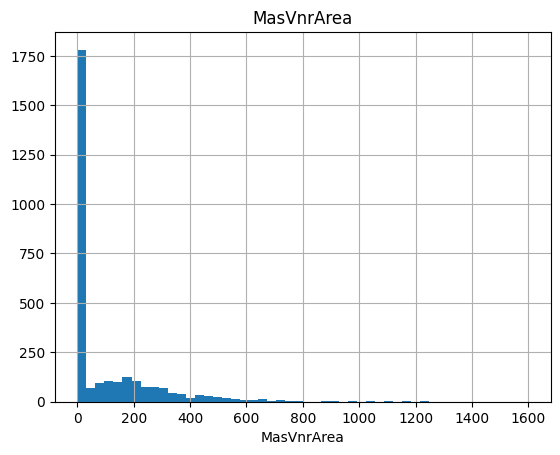

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: ExterQual, dtype: float64


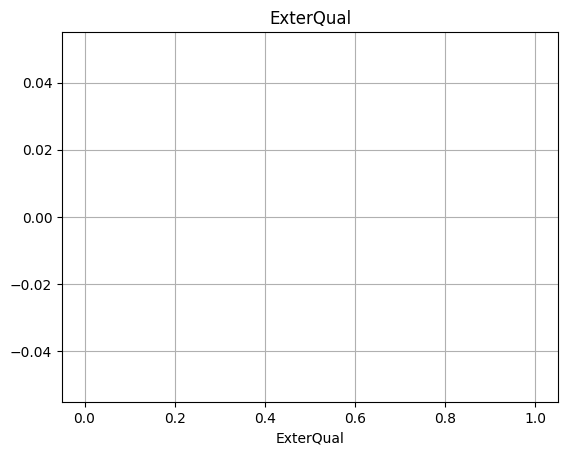

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: ExterCond, dtype: float64


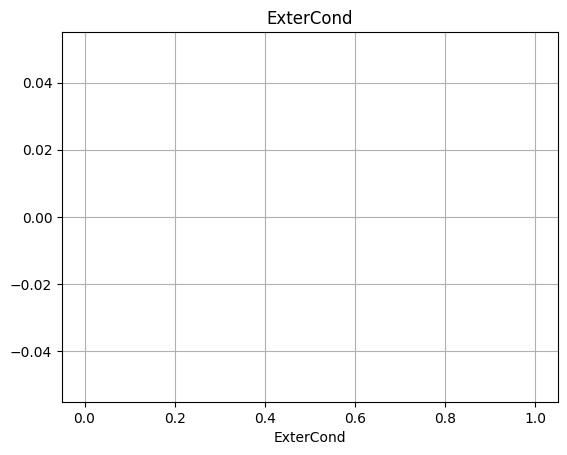

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Foundation, dtype: float64


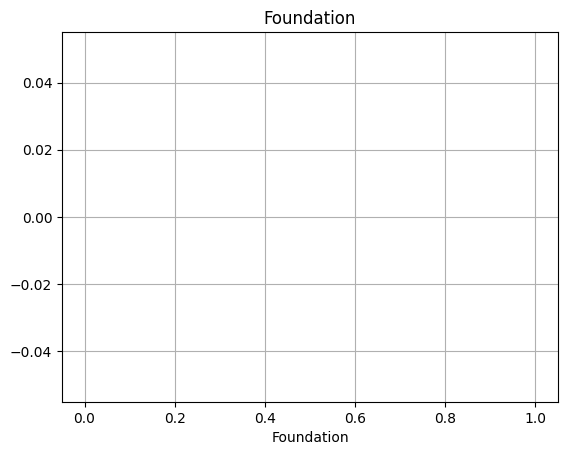

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: BsmtQual, dtype: float64


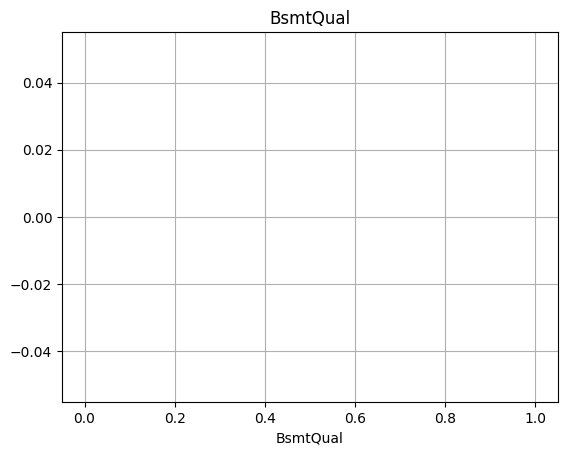

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: BsmtCond, dtype: float64


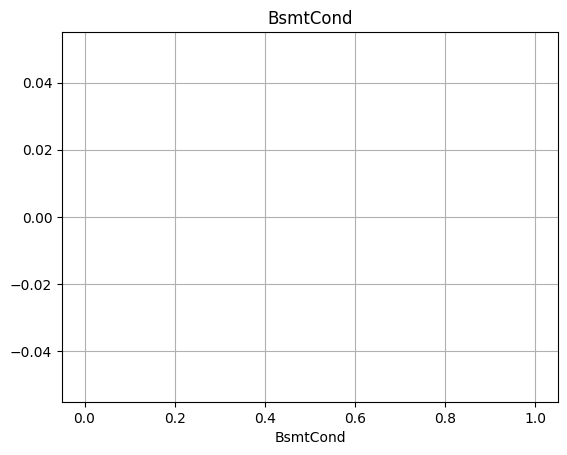

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: BsmtExposure, dtype: float64


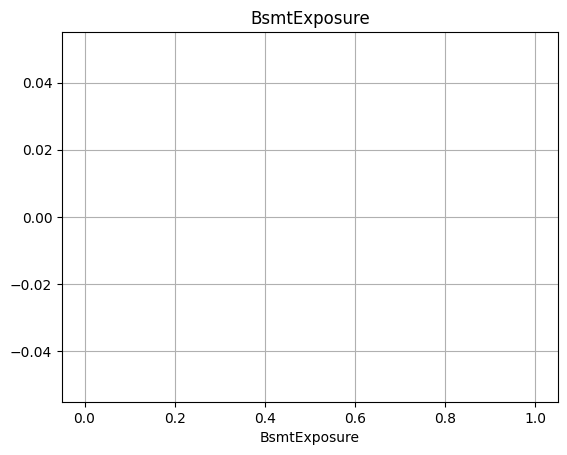

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: BsmtFinType1, dtype: float64


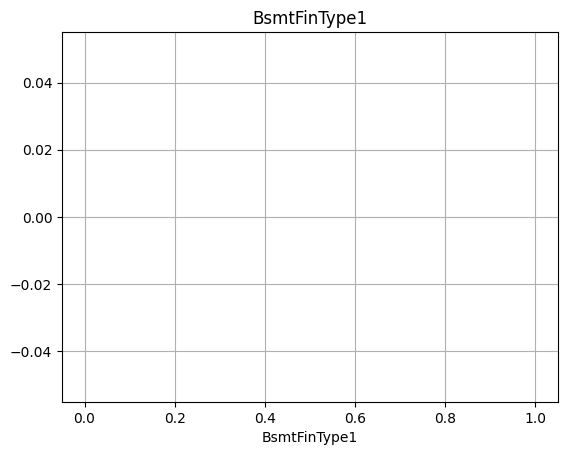

#####################################
count   2918.000
mean     441.423
std      455.611
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%      202.600
50%      368.500
60%      515.200
70%      656.000
80%      812.000
90%     1056.900
95%     1274.000
99%     1635.320
max     5644.000
Name: BsmtFinSF1, dtype: float64


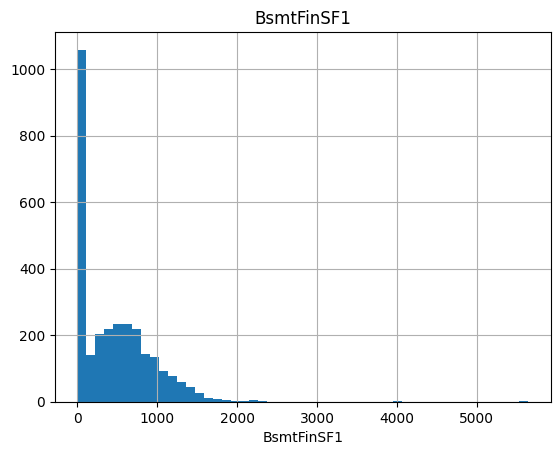

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: BsmtFinType2, dtype: float64


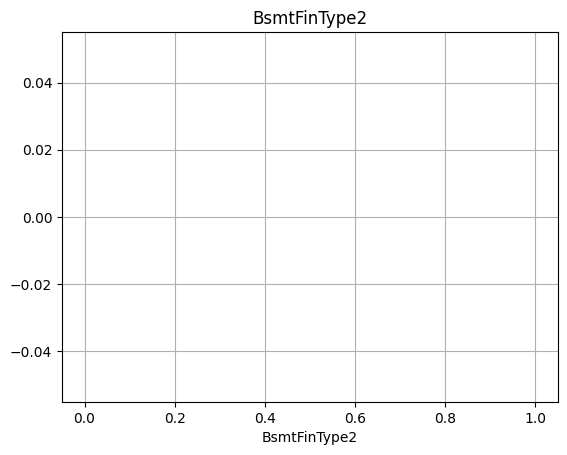

#####################################
count   2918.000
mean      49.582
std      169.206
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      125.600
95%      435.000
99%      874.660
max     1526.000
Name: BsmtFinSF2, dtype: float64


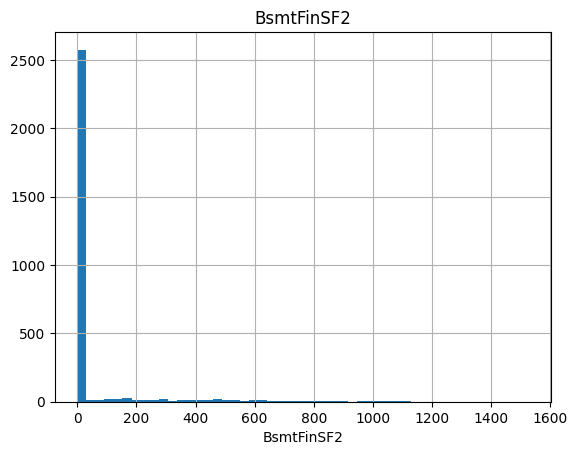

#####################################
count   2918.000
mean     560.772
std      439.544
min        0.000
5%         0.000
10%       56.000
20%      174.000
30%      270.000
40%      365.800
50%      467.000
60%      595.000
70%      732.000
80%      892.600
90%     1212.600
95%     1474.900
99%     1776.490
max     2336.000
Name: BsmtUnfSF, dtype: float64


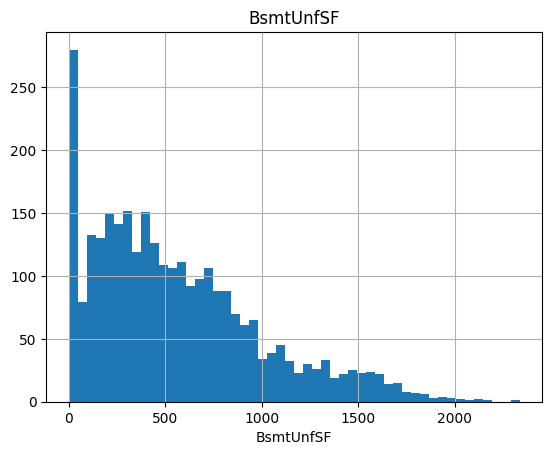

#####################################
count   2918.000
mean    1051.778
std      440.766
min        0.000
5%       455.250
10%      600.000
20%      741.000
30%      836.000
40%      911.000
50%      989.500
60%     1089.200
70%     1216.000
80%     1392.000
90%     1614.000
95%     1776.150
99%     2198.300
max     6110.000
Name: TotalBsmtSF, dtype: float64


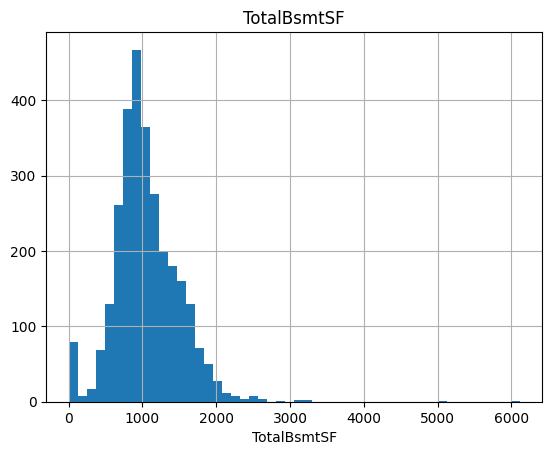

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Heating, dtype: float64


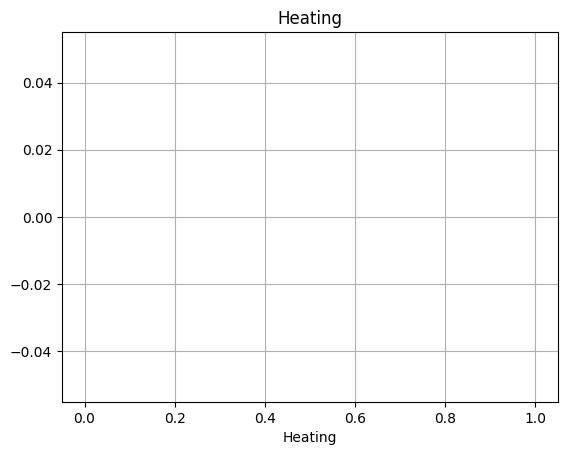

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: HeatingQC, dtype: float64


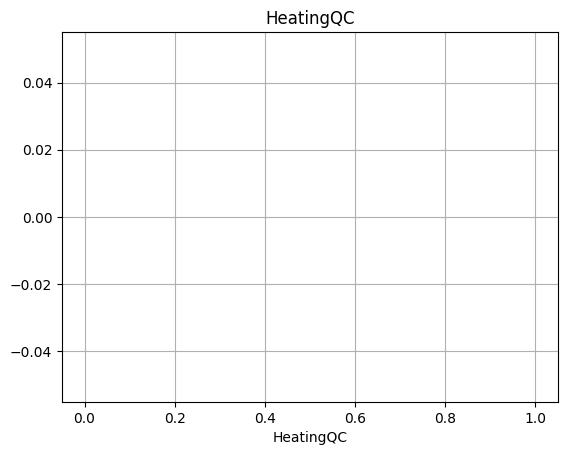

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: CentralAir, dtype: float64


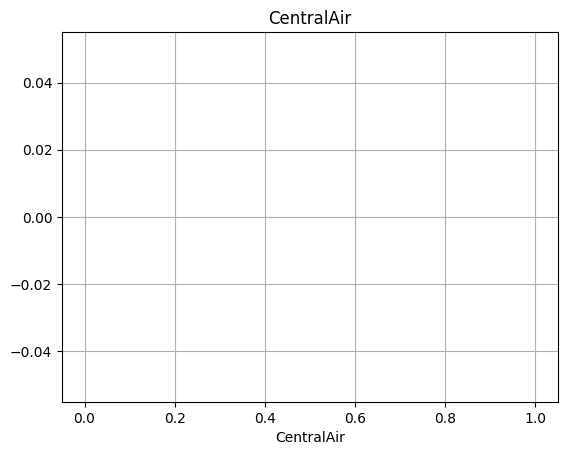

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Electrical, dtype: float64


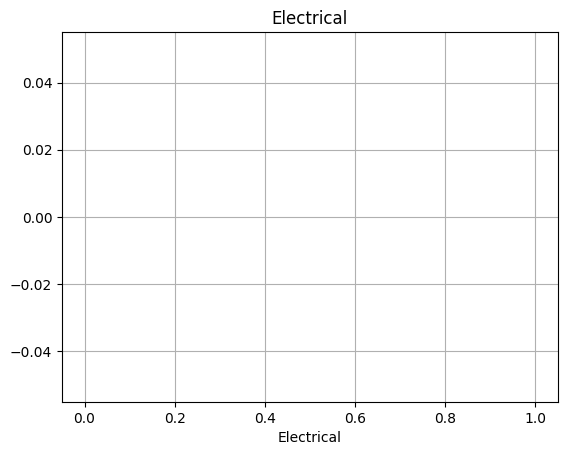

#####################################
count   2919.000
mean    1159.582
std      392.362
min      334.000
5%       665.900
10%      744.800
20%      847.000
30%      914.000
40%      996.200
50%     1082.000
60%     1180.000
70%     1314.000
80%     1483.400
90%     1675.000
95%     1830.100
99%     2288.020
max     5095.000
Name: 1stFlrSF, dtype: float64


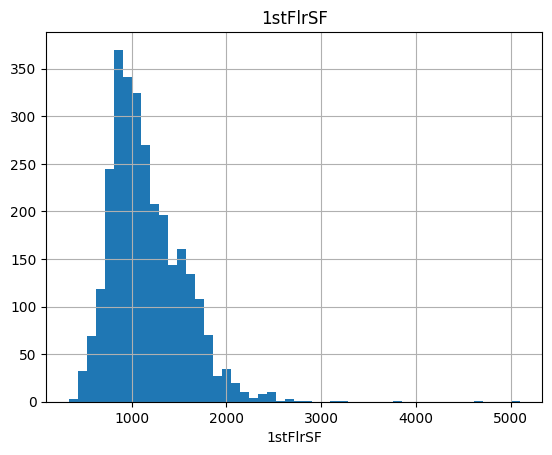

#####################################
count   2919.000
mean     336.484
std      428.701
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      427.400
70%      636.000
80%      770.800
90%      925.000
95%     1131.200
99%     1400.200
max     2065.000
Name: 2ndFlrSF, dtype: float64


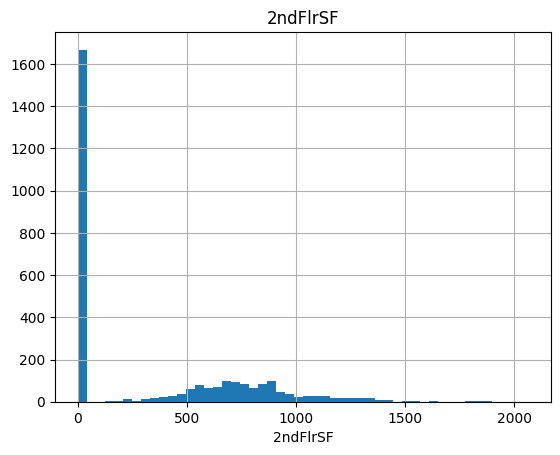

#####################################
count   2919.000
mean       4.694
std       46.397
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      153.840
max     1064.000
Name: LowQualFinSF, dtype: float64


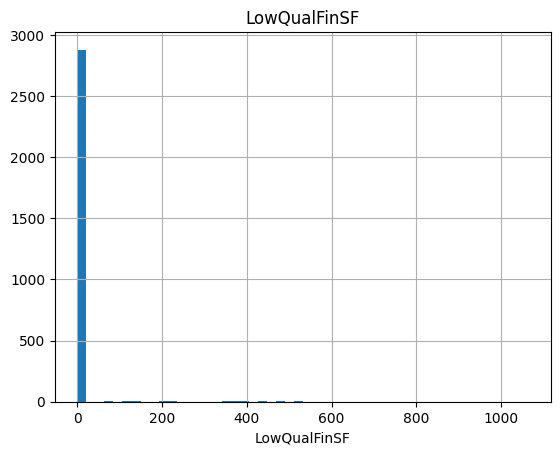

#####################################
count   2919.000
mean    1500.760
std      506.051
min      334.000
5%       861.000
10%      923.800
20%     1064.600
30%     1200.000
40%     1329.200
50%     1444.000
60%     1560.000
70%     1680.000
80%     1838.400
90%     2153.200
95%     2464.200
99%     2935.720
max     5642.000
Name: GrLivArea, dtype: float64


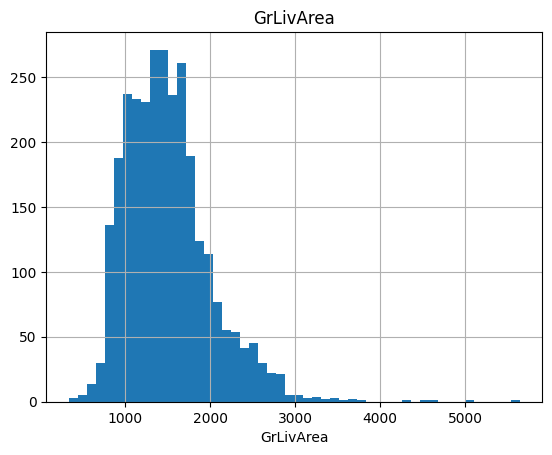

#####################################
count   2917.000
mean       0.430
std        0.525
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        1.000
70%        1.000
80%        1.000
90%        1.000
95%        1.000
99%        2.000
max        3.000
Name: BsmtFullBath, dtype: float64


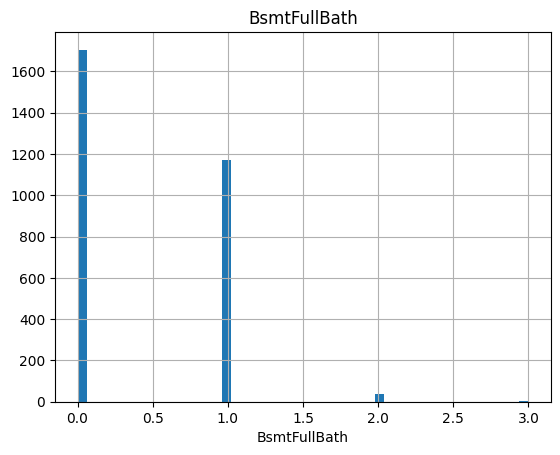

#####################################
count   2917.000
mean       0.061
std        0.246
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        1.000
99%        1.000
max        2.000
Name: BsmtHalfBath, dtype: float64


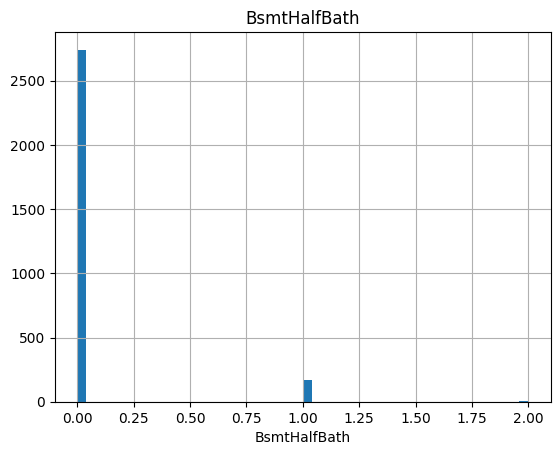

#####################################
count   2919.000
mean       1.568
std        0.553
min        0.000
5%         1.000
10%        1.000
20%        1.000
30%        1.000
40%        1.000
50%        2.000
60%        2.000
70%        2.000
80%        2.000
90%        2.000
95%        2.000
99%        3.000
max        4.000
Name: FullBath, dtype: float64


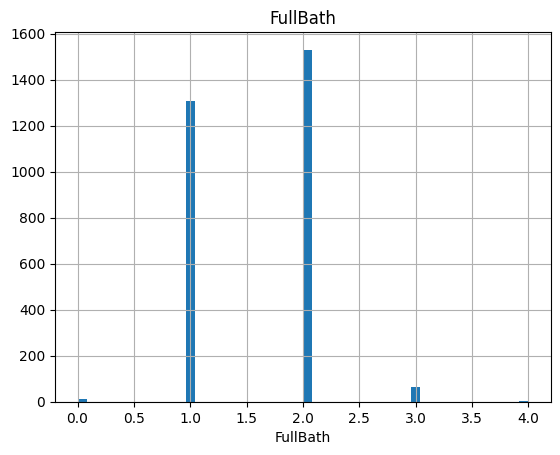

#####################################
count   2919.000
mean       0.380
std        0.503
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        1.000
80%        1.000
90%        1.000
95%        1.000
99%        1.000
max        2.000
Name: HalfBath, dtype: float64


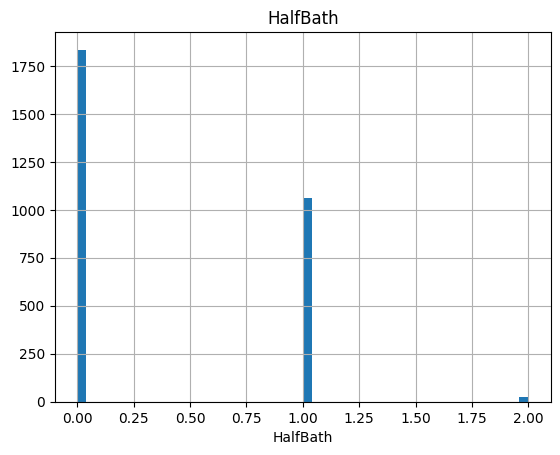

#####################################
count   2919.000
mean       2.860
std        0.823
min        0.000
5%         2.000
10%        2.000
20%        2.000
30%        3.000
40%        3.000
50%        3.000
60%        3.000
70%        3.000
80%        3.000
90%        4.000
95%        4.000
99%        5.000
max        8.000
Name: BedroomAbvGr, dtype: float64


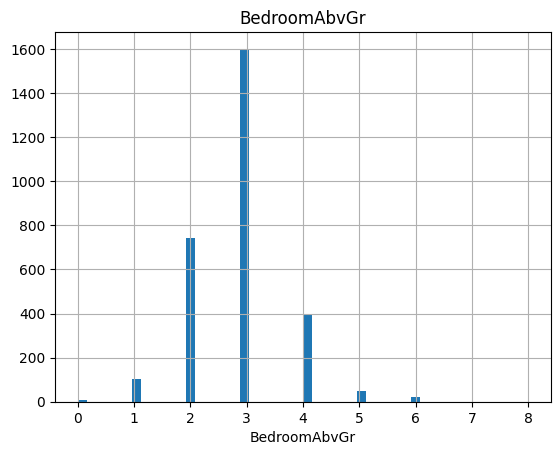

#####################################
count   2919.000
mean       1.045
std        0.214
min        0.000
5%         1.000
10%        1.000
20%        1.000
30%        1.000
40%        1.000
50%        1.000
60%        1.000
70%        1.000
80%        1.000
90%        1.000
95%        1.000
99%        2.000
max        3.000
Name: KitchenAbvGr, dtype: float64


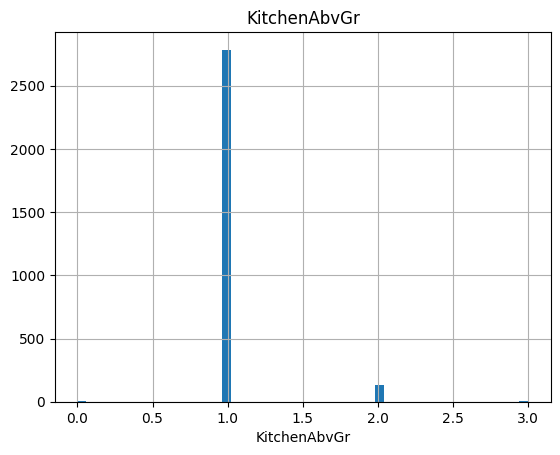

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: KitchenQual, dtype: float64


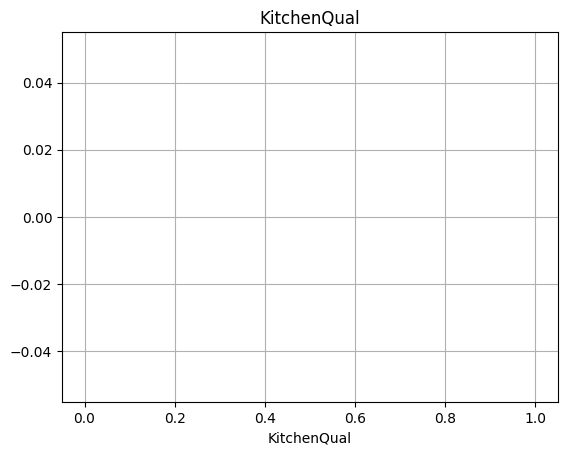

#####################################
count   2919.000
mean       6.452
std        1.569
min        2.000
5%         4.000
10%        5.000
20%        5.000
30%        6.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%        8.000
95%        9.000
99%       11.000
max       15.000
Name: TotRmsAbvGrd, dtype: float64


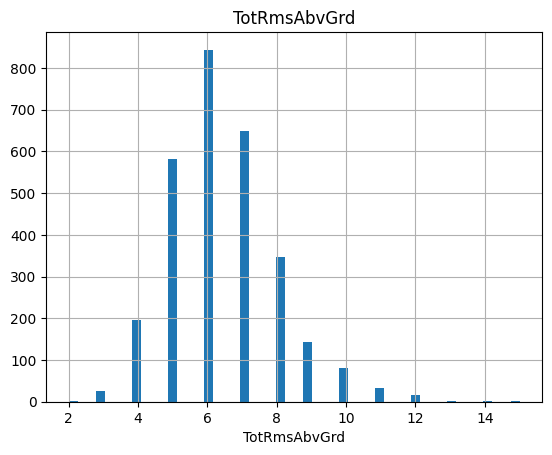

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Functional, dtype: float64


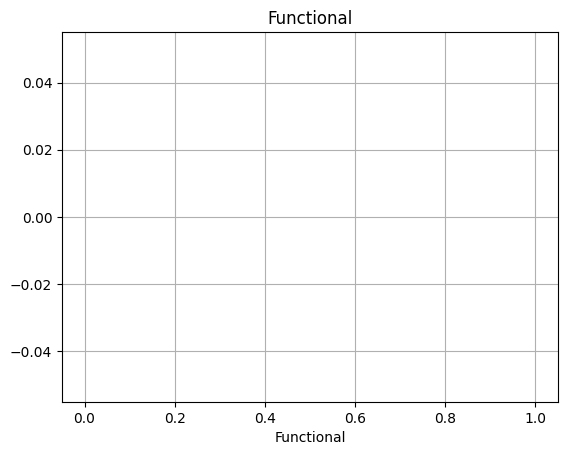

#####################################
count   2919.000
mean       0.597
std        0.646
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        1.000
60%        1.000
70%        1.000
80%        1.000
90%        1.000
95%        2.000
99%        2.000
max        4.000
Name: Fireplaces, dtype: float64


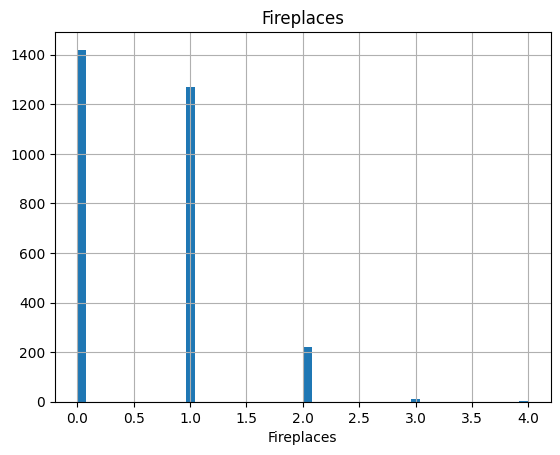

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: FireplaceQu, dtype: float64


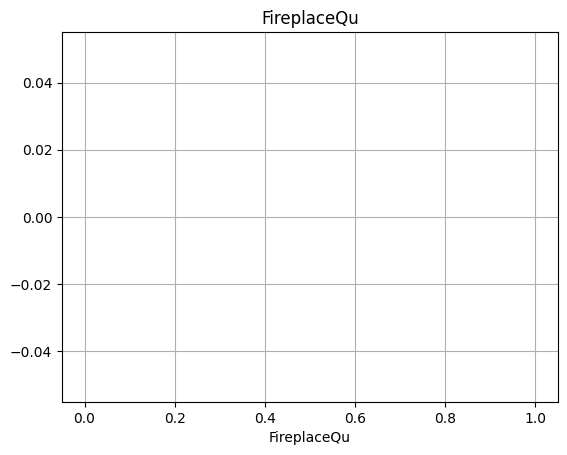

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: GarageType, dtype: float64


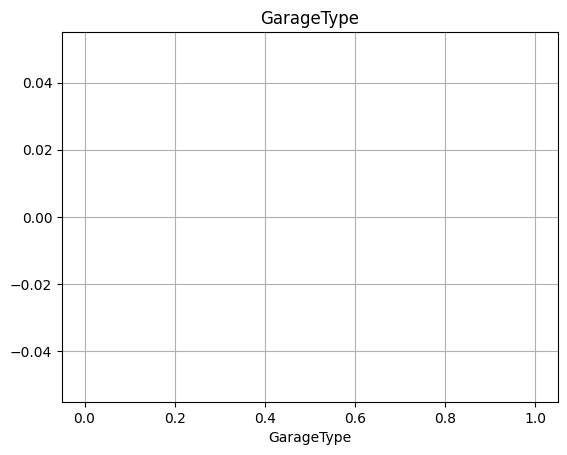

#####################################
count   2760.000
mean    1978.113
std       25.574
min     1895.000
5%      1928.000
10%     1941.000
20%     1957.000
30%     1964.000
40%     1972.000
50%     1979.000
60%     1993.000
70%     1999.000
80%     2004.000
90%     2006.000
95%     2007.000
99%     2009.000
max     2207.000
Name: GarageYrBlt, dtype: float64


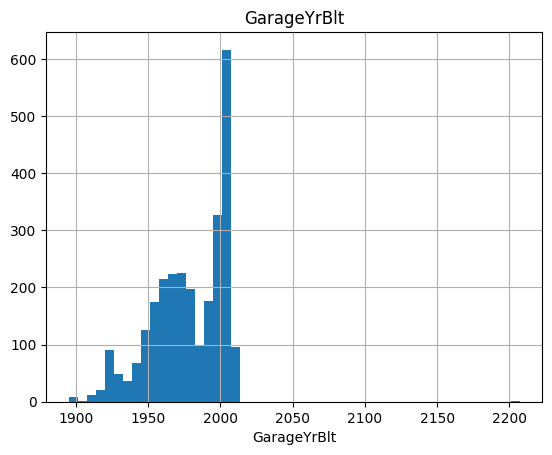

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: GarageFinish, dtype: float64


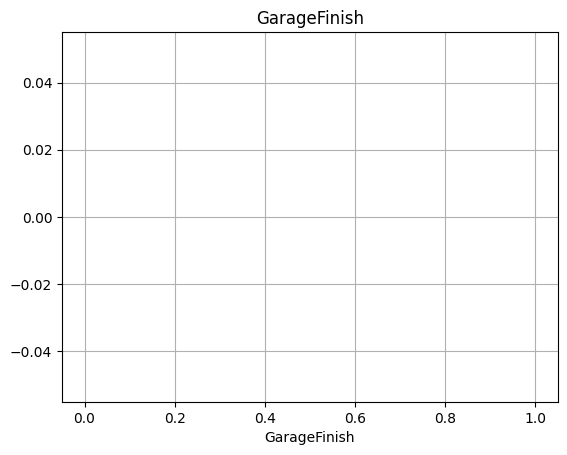

#####################################
count   2918.000
mean       1.767
std        0.762
min        0.000
5%         0.000
10%        1.000
20%        1.000
30%        1.000
40%        2.000
50%        2.000
60%        2.000
70%        2.000
80%        2.000
90%        3.000
95%        3.000
99%        3.000
max        5.000
Name: GarageCars, dtype: float64


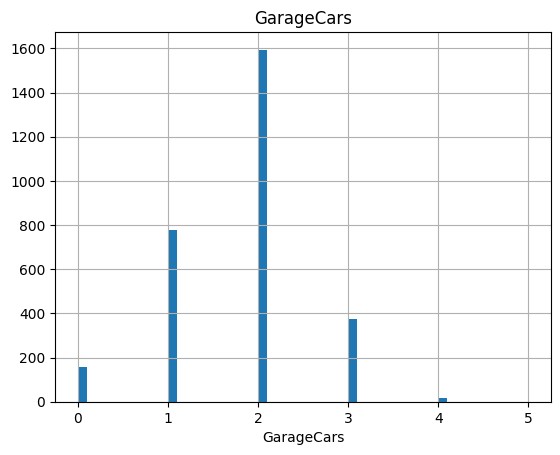

#####################################
count   2918.000
mean     472.875
std      215.395
min        0.000
5%         0.000
10%      240.000
20%      296.000
30%      379.000
40%      440.000
50%      480.000
60%      513.000
70%      560.900
80%      621.000
90%      758.000
95%      856.150
99%     1019.490
max     1488.000
Name: GarageArea, dtype: float64


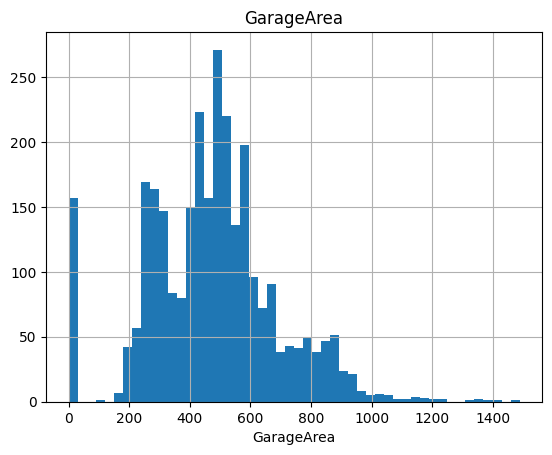

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: GarageQual, dtype: float64


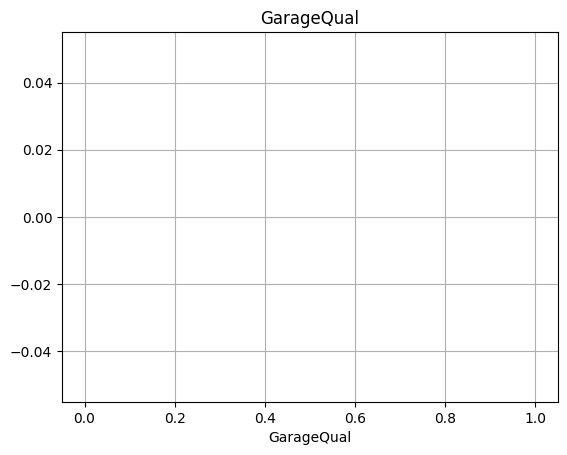

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: GarageCond, dtype: float64


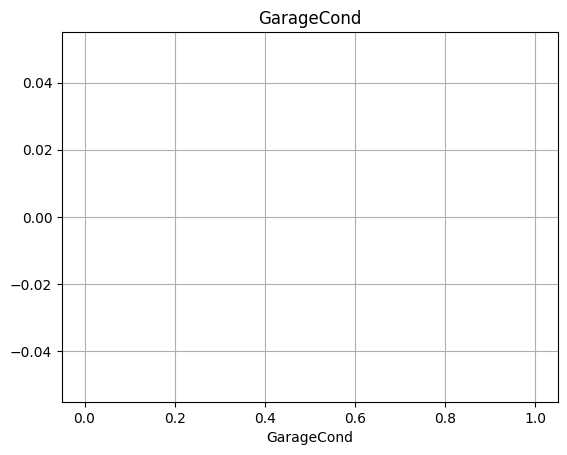

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: PavedDrive, dtype: float64


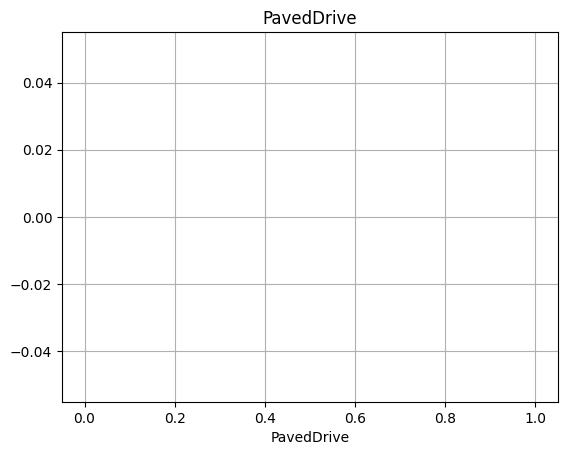

#####################################
count   2919.000
mean      93.710
std      126.527
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%      100.000
70%      144.000
80%      192.000
90%      257.000
95%      328.000
99%      500.820
max     1424.000
Name: WoodDeckSF, dtype: float64


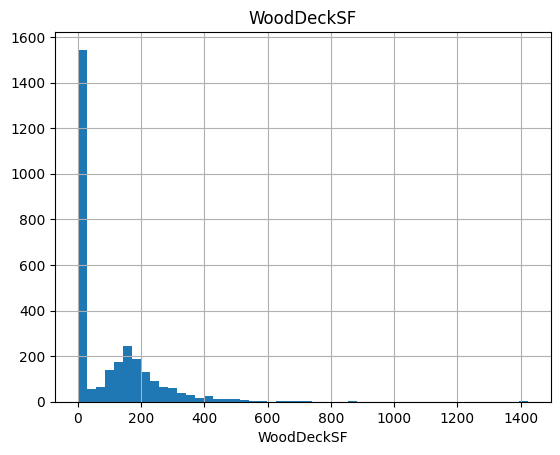

#####################################
count   2919.000
mean      47.487
std       67.575
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%       26.000
60%       40.000
70%       58.000
80%       85.000
90%      131.200
95%      183.100
99%      284.460
max      742.000
Name: OpenPorchSF, dtype: float64


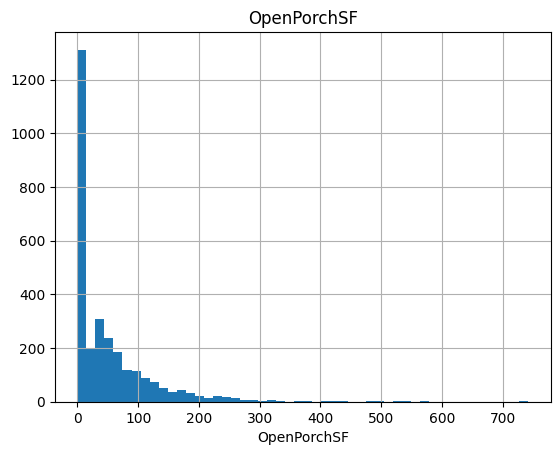

#####################################
count   2919.000
mean      23.098
std       64.244
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%      112.000
95%      176.000
99%      264.000
max     1012.000
Name: EnclosedPorch, dtype: float64


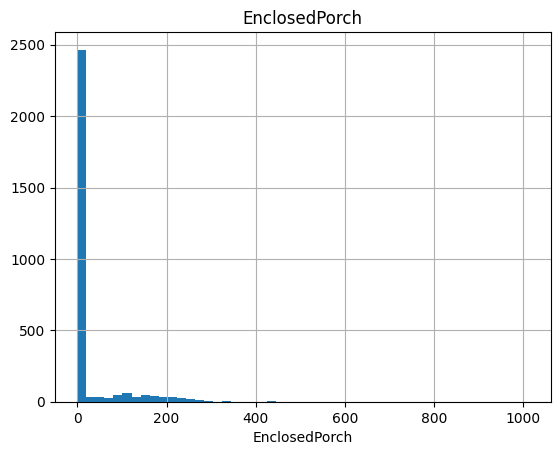

#####################################
count   2919.000
mean       2.602
std       25.188
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%      144.000
max      508.000
Name: 3SsnPorch, dtype: float64


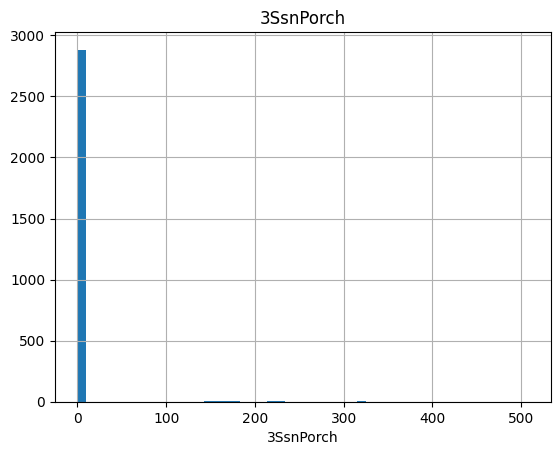

#####################################
count   2919.000
mean      16.062
std       56.184
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%      161.000
99%      259.820
max      576.000
Name: ScreenPorch, dtype: float64


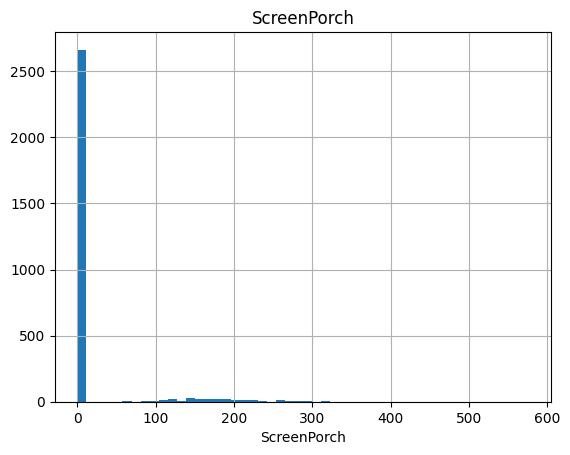

#####################################
count   2919.000
mean       2.252
std       35.664
min        0.000
5%         0.000
10%        0.000
20%        0.000
30%        0.000
40%        0.000
50%        0.000
60%        0.000
70%        0.000
80%        0.000
90%        0.000
95%        0.000
99%        0.000
max      800.000
Name: PoolArea, dtype: float64


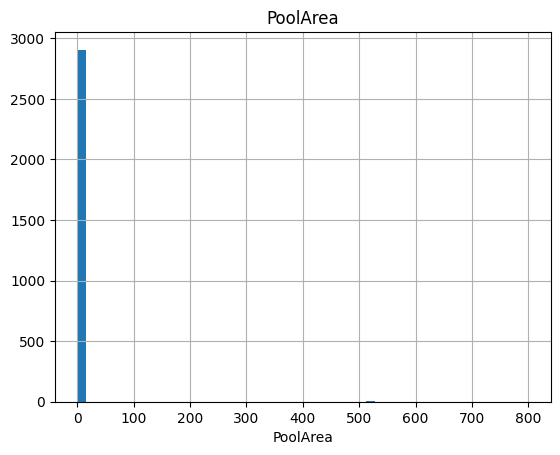

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: PoolQC, dtype: float64


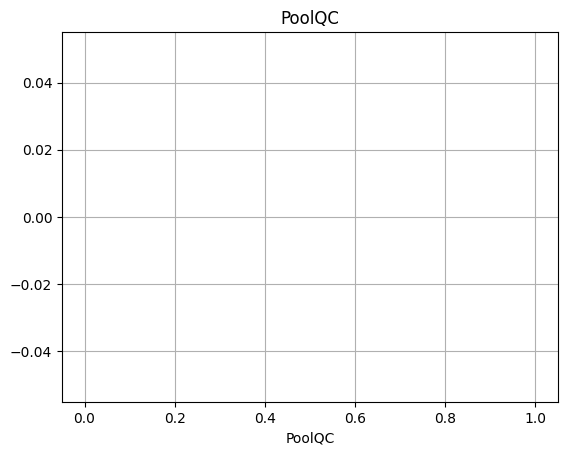

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: Fence, dtype: float64


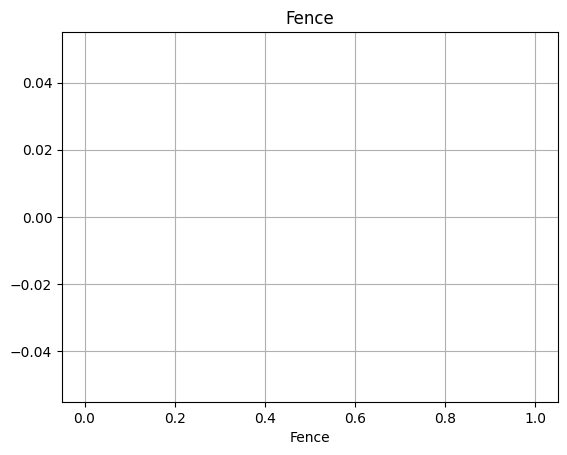

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: MiscFeature, dtype: float64


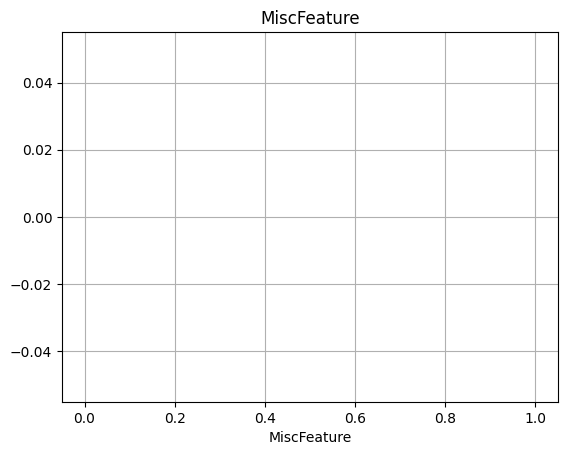

#####################################
count    2919.000
mean       50.826
std       567.402
min         0.000
5%          0.000
10%         0.000
20%         0.000
30%         0.000
40%         0.000
50%         0.000
60%         0.000
70%         0.000
80%         0.000
90%         0.000
95%         0.000
99%       982.000
max     17000.000
Name: MiscVal, dtype: float64


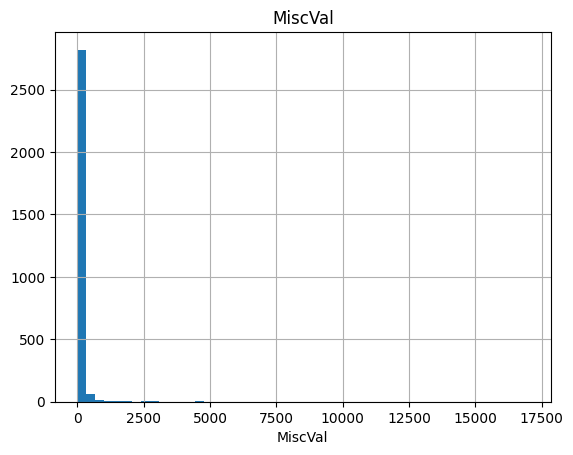

#####################################
count   2919.000
mean       6.213
std        2.715
min        1.000
5%         2.000
10%        3.000
20%        4.000
30%        5.000
40%        6.000
50%        6.000
60%        7.000
70%        7.000
80%        8.000
90%       10.000
95%       11.000
99%       12.000
max       12.000
Name: MoSold, dtype: float64


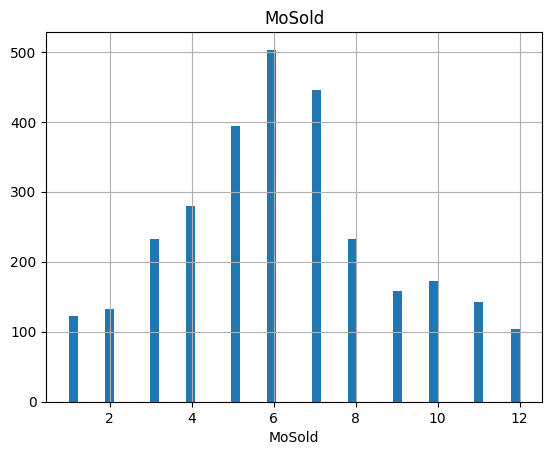

#####################################
count   2919.000
mean    2007.793
std        1.315
min     2006.000
5%      2006.000
10%     2006.000
20%     2006.000
30%     2007.000
40%     2007.000
50%     2008.000
60%     2008.000
70%     2009.000
80%     2009.000
90%     2010.000
95%     2010.000
99%     2010.000
max     2010.000
Name: YrSold, dtype: float64


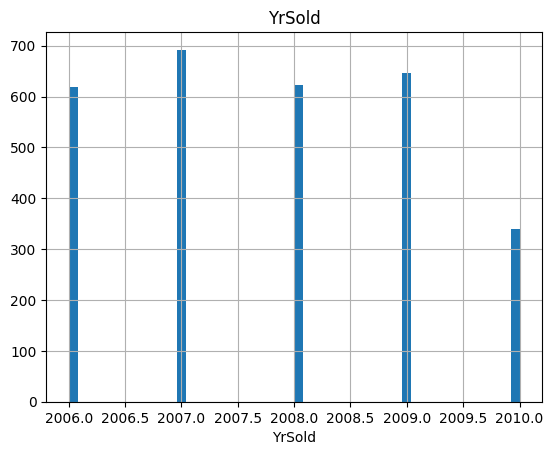

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: SaleType, dtype: float64


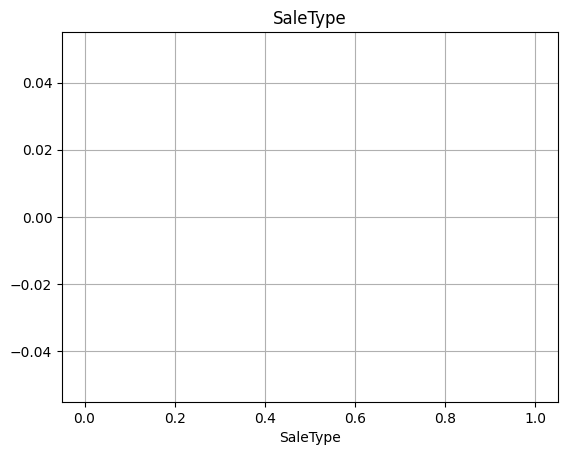

#####################################
count   0.000
mean      NaN
std       NaN
min       NaN
5%        NaN
10%       NaN
20%       NaN
30%       NaN
40%       NaN
50%       NaN
60%       NaN
70%       NaN
80%       NaN
90%       NaN
95%       NaN
99%       NaN
max       NaN
Name: SaleCondition, dtype: float64


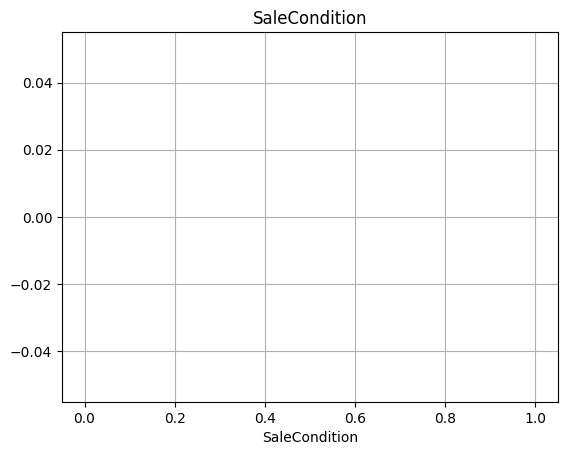

#####################################
count     1460.000
mean    180921.196
std      79442.503
min      34900.000
5%       88000.000
10%     106475.000
20%     124000.000
30%     135500.000
40%     147000.000
50%     163000.000
60%     179280.000
70%     198620.000
80%     230000.000
90%     278000.000
95%     326100.000
99%     442567.010
max     755000.000
Name: SalePrice, dtype: float64


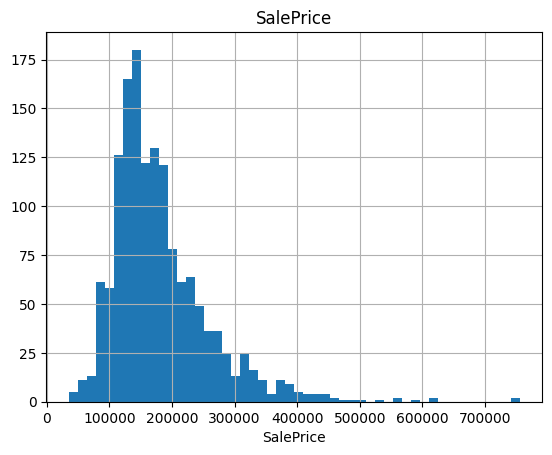

#####################################


In [35]:
# Sayısal sütunları tanımla
num_cols = df.select_dtypes(include=['number']).columns

# Sayısal sütunları özetle
for col in num_cols:
    num_summary(df, col, True)



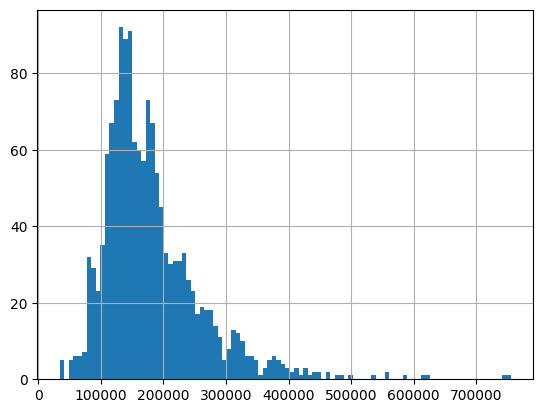

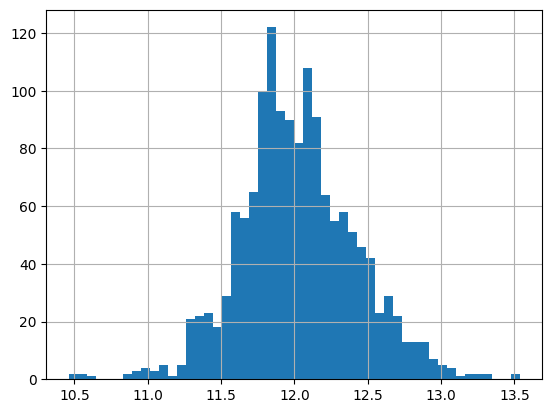

In [34]:

def target_summary_with_cat(dataframe, target, categorical_col):
    print(pd.DataFrame({"TARGET_MEAN": dataframe.groupby(categorical_col)[target].mean()}), end="\n\n\n")


for col in cat_cols:
    target_summary_with_cat(df,"SalePrice",col)


# Bağımlı değişkenin incelenmesi
df["SalePrice"].hist(bins=100)
plt.show()

# Bağımlı değişkenin logaritmasının incelenmesi
np.log1p(df['SalePrice']).hist(bins=50)
plt.show()


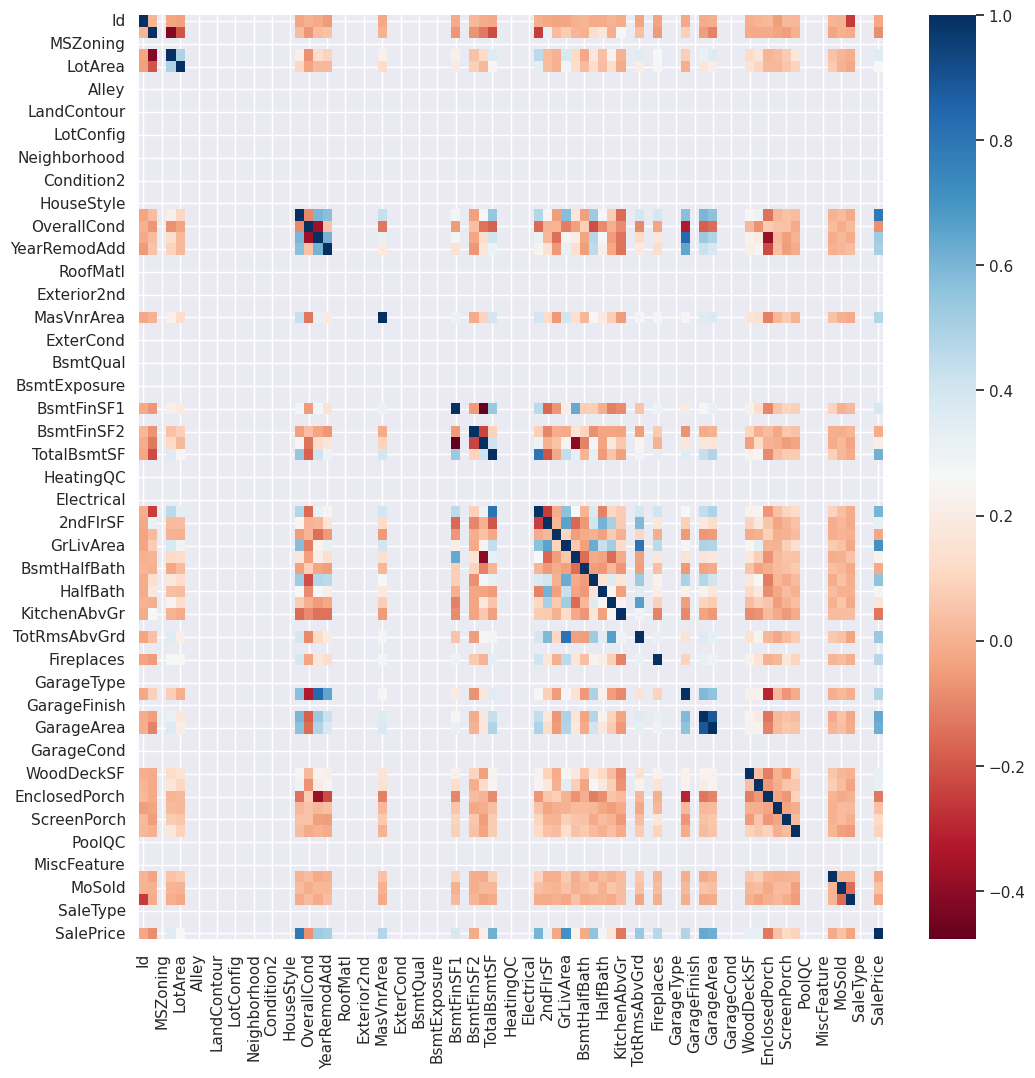

In [37]:

# Korelasyon hesaplama
corr = df[num_cols].corr()
sns.set(rc={'figure.figsize': (12, 12)})
sns.heatmap(corr, cmap="RdBu")
plt.show()

# Fonksiyon tanımı
def high_correlated_cols(dataframe, plot=False, corr_th=0.70):
    # Korelasyon hesapla
    corr = dataframe.corr()
    cor_matrix = corr.abs()

    # Üst üçgeni al
    upper_triangle_matrix = cor_matrix.where(np.triu(np.ones(cor_matrix.shape), k=1).astype(bool))

    # Korelasyonu yüksek olan sütunları seç
    drop_list = [col for col in upper_triangle_matrix.columns if any(upper_triangle_matrix[col] > corr_th)]

    # Korelasyonu görselleştir
    if plot:
        sns.set(rc={'figure.figsize': (15, 15)})
        sns.heatmap(corr, cmap="RdBu")
        plt.show()

    return drop_list

# Fonksiyonu çalıştır
drop_list = high_correlated_cols(df, plot=False)


Görev 2 : Feature Engineering

In [38]:
# Aykırı değerlerin baskılanması
def outlier_thresholds(dataframe, variable, low_quantile=0.10, up_quantile=0.90):
    quantile_one = dataframe[variable].quantile(low_quantile)
    quantile_three = dataframe[variable].quantile(up_quantile)
    interquantile_range = quantile_three - quantile_one
    up_limit = quantile_three + 1.5 * interquantile_range
    low_limit = quantile_one - 1.5 * interquantile_range
    return low_limit, up_limit


In [39]:
# Aykırı değer kontrolü
def check_outlier(dataframe, col_name):
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False


for col in num_cols:
    if col != "SalePrice":
      print(col, check_outlier(df, col))

Id False
MSSubClass False
MSZoning False
LotFrontage True
LotArea True
Street False
Alley False
LotShape False
LandContour False
Utilities False
LotConfig False
LandSlope False
Neighborhood False
Condition1 False
Condition2 False
BldgType False
HouseStyle False
OverallQual False
OverallCond True
YearBuilt False
YearRemodAdd False
RoofStyle False
RoofMatl False
Exterior1st False
Exterior2nd False
MasVnrType False
MasVnrArea True
ExterQual False
ExterCond False
Foundation False
BsmtQual False
BsmtCond False
BsmtExposure False
BsmtFinType1 False
BsmtFinSF1 True
BsmtFinType2 False
BsmtFinSF2 True
BsmtUnfSF False
TotalBsmtSF True
Heating False
HeatingQC False
CentralAir False
Electrical False
1stFlrSF True
2ndFlrSF False
LowQualFinSF True
GrLivArea True
BsmtFullBath True
BsmtHalfBath True
FullBath True
HalfBath False
BedroomAbvGr True
KitchenAbvGr True
KitchenQual False
TotRmsAbvGrd True
Functional False
Fireplaces True
FireplaceQu False
GarageType False
GarageYrBlt True
GarageFinish False


In [72]:
# Aykırı değerlerin baskılanması
def replace_with_thresholds(dataframe, variable):
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit


for col in num_cols:
    if col != "SalePrice":
        replace_with_thresholds(df,col)



In [41]:
# Eksik Değer Analizi
def missing_values_table(dataframe, na_name=False):
    na_columns = [col for col in dataframe.columns if dataframe[col].isnull().sum() > 0]

    n_miss = dataframe[na_columns].isnull().sum().sort_values(ascending=False)

    ratio = (dataframe[na_columns].isnull().sum() / dataframe.shape[0] * 100).sort_values(ascending=False)

    missing_df = pd.concat([n_miss, np.round(ratio, 2)], axis=1, keys=['n_miss', 'ratio'])

    print(missing_df, end="\n")

    if na_name:
        return na_columns

missing_values_table(df)


df["Alley"].value_counts()
df["BsmtQual"].value_counts()

               n_miss   ratio
MSZoning         2919 100.000
Heating          2919 100.000
BsmtCond         2919 100.000
BsmtExposure     2919 100.000
BsmtFinType1     2919 100.000
SaleType         2919 100.000
BsmtFinType2     2919 100.000
MiscFeature      2919 100.000
Fence            2919 100.000
PoolQC           2919 100.000
HeatingQC        2919 100.000
Foundation       2919 100.000
CentralAir       2919 100.000
Electrical       2919 100.000
PavedDrive       2919 100.000
GarageCond       2919 100.000
KitchenQual      2919 100.000
Functional       2919 100.000
FireplaceQu      2919 100.000
GarageType       2919 100.000
BsmtQual         2919 100.000
ExterCond        2919 100.000
GarageFinish     2919 100.000
Condition1       2919 100.000
Street           2919 100.000
Alley            2919 100.000
LotShape         2919 100.000
LandContour      2919 100.000
Utilities        2919 100.000
LotConfig        2919 100.000
LandSlope        2919 100.000
Neighborhood     2919 100.000
Condition2

Series([], Name: count, dtype: int64)

In [42]:
# Bazı değişkenlerdeki boş değerler evin o özelliğe sahip olmadığını ifade etmektedir
no_cols = ["Alley","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","FireplaceQu",
           "GarageType","GarageFinish","GarageQual","GarageCond","PoolQC","Fence","MiscFeature"]

In [43]:
# Kolonlardaki boşlukların "No" ifadesi ile doldurulması
for col in no_cols:
    df[col].fillna("No",inplace=True)

missing_values_table(df)

               n_miss   ratio
MSZoning         2919 100.000
Exterior1st      2919 100.000
SaleCondition    2919 100.000
SaleType         2919 100.000
PavedDrive       2919 100.000
Functional       2919 100.000
KitchenQual      2919 100.000
Electrical       2919 100.000
CentralAir       2919 100.000
HeatingQC        2919 100.000
Heating          2919 100.000
Foundation       2919 100.000
ExterQual        2919 100.000
MasVnrType       2919 100.000
Exterior2nd      2919 100.000
ExterCond        2919 100.000
RoofMatl         2919 100.000
Condition2       2919 100.000
Street           2919 100.000
LotShape         2919 100.000
LandContour      2919 100.000
Utilities        2919 100.000
LotConfig        2919 100.000
LandSlope        2919 100.000
RoofStyle        2919 100.000
Condition1       2919 100.000
Neighborhood     2919 100.000
BldgType         2919 100.000
HouseStyle       2919 100.000
SalePrice        1459  49.980
LotFrontage       486  16.650
GarageYrBlt       159   5.450
MasVnrArea

In [44]:
# Bu fonsksiyon eksik değerlerin median veya mean ile doldurulmasını sağlar

def quick_missing_imp(data, num_method="median", cat_length=20, target="SalePrice"):
    variables_with_na = [col for col in data.columns if data[col].isnull().sum() > 0]  # Eksik değere sahip olan değişkenler listelenir

    temp_target = data[target]

    print("# BEFORE")
    print(data[variables_with_na].isnull().sum(), "\n\n")  # Uygulama öncesi değişkenlerin eksik değerlerinin sayısı

    # değişken object ve sınıf sayısı cat_lengthe eşit veya altındaysa boş değerleri mode ile doldur
    data = data.apply(lambda x: x.fillna(x.mode()[0]) if (x.dtype == "O" and len(x.unique()) <= cat_length) else x, axis=0)

    # num_method mean ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    if num_method == "mean":
        data = data.apply(lambda x: x.fillna(x.mean()) if x.dtype != "O" else x, axis=0)
    # num_method median ise tipi object olmayan değişkenlerin boş değerleri ortalama ile dolduruluyor
    elif num_method == "median":
        data = data.apply(lambda x: x.fillna(x.median()) if x.dtype != "O" else x, axis=0)

    data[target] = temp_target

    print("# AFTER \n Imputation method is 'MODE' for categorical variables!")
    print(" Imputation method is '" + num_method.upper() + "' for numeric variables! \n")
    print(data[variables_with_na].isnull().sum(), "\n\n")

    return data


df = quick_missing_imp(df, num_method="median", cat_length=17)



# BEFORE
MSZoning         2919
LotFrontage       486
Street           2919
LotShape         2919
LandContour      2919
Utilities        2919
LotConfig        2919
LandSlope        2919
Neighborhood     2919
Condition1       2919
Condition2       2919
BldgType         2919
HouseStyle       2919
RoofStyle        2919
RoofMatl         2919
Exterior1st      2919
Exterior2nd      2919
MasVnrType       2919
MasVnrArea         23
ExterQual        2919
ExterCond        2919
Foundation       2919
BsmtFinSF1          1
BsmtFinSF2          1
BsmtUnfSF           1
TotalBsmtSF         1
Heating          2919
HeatingQC        2919
CentralAir       2919
Electrical       2919
BsmtFullBath        2
BsmtHalfBath        2
KitchenQual      2919
Functional       2919
GarageYrBlt       159
GarageCars          1
GarageArea          1
PavedDrive       2919
SaleType         2919
SaleCondition    2919
SalePrice        1459
dtype: int64 


# AFTER 
 Imputation method is 'MODE' for categorical variables!
 Imputat

In [45]:
# Kategorik kolonların dağılımının incelenmesi
def rare_analyser(dataframe, target, cat_cols):
    for col in cat_cols:
        print(col, ":", len(dataframe[col].value_counts()))
        print(pd.DataFrame({"COUNT": dataframe[col].value_counts(),
                            "RATIO": dataframe[col].value_counts() / len(dataframe),
                            "TARGET_MEAN": dataframe.groupby(col)[target].mean()}), end="\n\n\n")

rare_analyser(df, "SalePrice", cat_cols)


In [47]:
# Nadir sınıfların tespit edilmesi
def rare_encoder(dataframe, rare_perc):
    temp_df = dataframe.copy()

    rare_columns = [col for col in temp_df.columns if temp_df[col].dtypes == 'O'
                    and (temp_df[col].value_counts() / len(temp_df) < rare_perc).any(axis=None)]

    for var in rare_columns:
        tmp = temp_df[var].value_counts() / len(temp_df)
        rare_labels = tmp[tmp < rare_perc].index
        temp_df[var] = np.where(temp_df[var].isin(rare_labels), 'Rare', temp_df[var])

    return temp_df

    rare_encoder(df,0.01)

In [50]:
# yeni değişkenler oluş ve oluşturduğun yeni değişkenlerin başına 'NEW' ekle.
# Sayısal olmayan verileri NaN'a dönüştür
cols = ["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
        "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual",
        "GarageCond", "Fence", "1stFlrSF", "GrLivArea", "GarageArea"]

# Verileri sayısal hale getir
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

# Yeni özellikler oluştur
df["NEW_1st*GrLiv"] = df["1stFlrSF"] * df["GrLivArea"]
df["NEW_Garage*GrLiv"] = df["GarageArea"] * df["GrLivArea"]

# TotalQual hesapla
df["TotalQual"] = df[["OverallQual", "OverallCond", "ExterQual", "ExterCond", "BsmtCond", "BsmtFinType1",
                      "BsmtFinType2", "HeatingQC", "KitchenQual", "Functional", "FireplaceQu", "GarageQual",
                      "GarageCond", "Fence"]].sum(axis=1)  # 42



In [51]:
# Total Floor
df["NEW_TotalFlrSF"] = df["1stFlrSF"] + df["2ndFlrSF"] # 32

# Total Finished Basement Area
df["NEW_TotalBsmtFin"] = df.BsmtFinSF1 + df.BsmtFinSF2 # 56

# Porch Area
df["NEW_PorchArea"] = df.OpenPorchSF + df.EnclosedPorch + df.ScreenPorch + df["3SsnPorch"] + df.WoodDeckSF # 93

# Total House Area
df["NEW_TotalHouseArea"] = df.NEW_TotalFlrSF + df.TotalBsmtSF # 156

df["NEW_TotalSqFeet"] = df.GrLivArea + df.TotalBsmtSF # 35


In [52]:
# Lot Ratio
df["NEW_LotRatio"] = df.GrLivArea / df.LotArea # 64

df["NEW_RatioArea"] = df.NEW_TotalHouseArea / df.LotArea # 57

df["NEW_GarageLotRatio"] = df.GarageArea / df.LotArea # 69

# MasVnrArea
df["NEW_MasVnrRatio"] = df.MasVnrArea / df.NEW_TotalHouseArea # 36

# Dif Area
df["NEW_DifArea"] = (df.LotArea - df["1stFlrSF"] - df.GarageArea - df.NEW_PorchArea - df.WoodDeckSF) # 73


df["NEW_OverallGrade"] = df["OverallQual"] * df["OverallCond"] # 61


df["NEW_Restoration"] = df.YearRemodAdd - df.YearBuilt # 31

df["NEW_HouseAge"] = df.YrSold - df.YearBuilt # 73

df["NEW_RestorationAge"] = df.YrSold - df.YearRemodAdd # 40

df["NEW_GarageAge"] = df.GarageYrBlt - df.YearBuilt # 17

df["NEW_GarageRestorationAge"] = np.abs(df.GarageYrBlt - df.YearRemodAdd) # 30

df["NEW_GarageSold"] = df.YrSold - df.GarageYrBlt # 48




In [53]:
drop_list = ["Street", "Alley", "LandContour", "Utilities", "LandSlope","Heating", "PoolQC", "MiscFeature","Neighborhood"]

# drop_list'teki değişkenlerin düşürülmesi
df.drop(drop_list, axis=1, inplace=True)

In [56]:
# Grab column names fonksiyonunu çağır
col_names_result = grab_col_names(df)

# Sonucu yazdır
print(col_names_result)


Observations: 2919
Variables: 92
cat_cols: 49
num_cols: 43
cat_but_car: 0
num_but_cat: 45
None


In [58]:
def grab_col_names(dataframe):
    cat_cols = [col for col in dataframe.columns if dataframe[col].dtype == 'O']
    num_cols = [col for col in dataframe.columns if dataframe[col].dtype != 'O']
    cat_but_car = [col for col in cat_cols if dataframe[col].nunique() > 20]  # Veya başka bir kriter
    num_but_cat = [col for col in num_cols if dataframe[col].nunique() <= 20]

    return cat_cols, cat_but_car, num_cols



In [59]:
# Fonksiyonu kontrol et
cat_cols, cat_but_car, num_cols = grab_col_names(df)

# Sonuçları yazdır
print("Categorical Columns:", cat_cols)
print("Categorical but Cardinal Columns:", cat_but_car)
print("Numerical Columns:", num_cols)


Categorical Columns: ['BsmtQual', 'BsmtExposure', 'GarageType', 'GarageFinish']
Categorical but Cardinal Columns: []
Numerical Columns: ['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'LotShape', 'LotConfig', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond', 'PavedDrive', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'Fence', 'MiscVal

In [60]:
cat_cols = [col for col in df.columns if df[col].dtype == 'O']
num_cols = [col for col in df.columns if df[col].dtype != 'O']


In [62]:
# Label Encoding & One-Hot Encoding işlemlerini uygula
cat_cols, cat_but_car, num_cols = grab_col_names(df)

def label_encoder(dataframe, binary_col):
    labelencoder = LabelEncoder()
    dataframe[binary_col] = labelencoder.fit_transform(dataframe[binary_col])
    return dataframe

binary_cols = [col for col in df.columns if df[col].dtypes == "O" and len(df[col].unique()) == 2]

for col in binary_cols:
    label_encoder(df, col)


def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=drop_first)
    return dataframe

df = one_hot_encoder(df, cat_cols, drop_first=True)




In [64]:
# MODELLEME

#  Train ve Test verisini ayır. (SalePrice değişkeni boş olan değerler test verisi.)
train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

y = train_df['SalePrice'] # np.log1p(df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

In [71]:
# Train verisi ile model kurup, model başarısını değerlendiriniz.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)

models = [('LR', LinearRegression()),
          #("Ridge", Ridge()),
          #("Lasso", Lasso()),
          #("ElasticNet", ElasticNet()),
          ('KNN', KNeighborsRegressor()),
          ('CART', DecisionTreeRegressor()),
          ('RF', RandomForestRegressor()),
          #('SVR', SVR()),
          ('GBM', GradientBoostingRegressor()),
          ("XGBoost", XGBRegressor(objective='reg:squarederror')),
          ("LightGBM", LGBMRegressor())]
          # ("CatBoost", CatBoostRegressor(verbose=False))]



In [83]:
numerik_degiskenler = df.select_dtypes(include=['int64', 'float64']).columns.tolist()
outlier_report = {}
for col in numerik_degiskenler:
    try:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)]
        outlier_count = outliers.shape[0]
        outlier_report[col] = outlier_count
    except Exception as e:
        print(f"Hata {col} sütununda: {e}")
print("Aykırı Gözlem Sayısı:")
for col, count in outlier_report.items():
    print(f"{col}: {count} aykırı gözlem")

Aykırı Gözlem Sayısı:
Id: 0 aykırı gözlem
MSSubClass: 207 aykırı gözlem
MSZoning: 0 aykırı gözlem
LotFrontage: 260 aykırı gözlem
LotArea: 128 aykırı gözlem
LotShape: 0 aykırı gözlem
LotConfig: 0 aykırı gözlem
Condition1: 0 aykırı gözlem
Condition2: 0 aykırı gözlem
BldgType: 0 aykırı gözlem
HouseStyle: 0 aykırı gözlem
OverallQual: 4 aykırı gözlem
OverallCond: 252 aykırı gözlem
YearBuilt: 9 aykırı gözlem
YearRemodAdd: 0 aykırı gözlem
RoofStyle: 0 aykırı gözlem
RoofMatl: 0 aykırı gözlem
Exterior1st: 0 aykırı gözlem
Exterior2nd: 0 aykırı gözlem
MasVnrType: 0 aykırı gözlem
MasVnrArea: 202 aykırı gözlem
ExterQual: 0 aykırı gözlem
ExterCond: 0 aykırı gözlem
Foundation: 0 aykırı gözlem
BsmtCond: 0 aykırı gözlem
BsmtFinType1: 0 aykırı gözlem
BsmtFinSF1: 15 aykırı gözlem
BsmtFinType2: 0 aykırı gözlem
BsmtFinSF2: 347 aykırı gözlem
BsmtUnfSF: 53 aykırı gözlem
TotalBsmtSF: 122 aykırı gözlem
HeatingQC: 0 aykırı gözlem
CentralAir: 0 aykırı gözlem
Electrical: 0 aykırı gözlem
1stFlrSF: 42 aykırı gözlem

In [95]:
# Log dönüşümünün gerçekleştirilmesi


train_df = df[df['SalePrice'].notnull()]
test_df = df[df['SalePrice'].isnull()]

y = np.log1p(train_df['SalePrice'])
X = train_df.drop(["Id", "SalePrice"], axis=1)

# Verinin eğitim ve tet verisi olarak bölünmesi
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=17)


In [96]:
# lgbm_tuned = LGBMRegressor(**lgbm_gs_best.best_params_).fit(X_train, y_train)

lgbm = LGBMRegressor().fit(X_train, y_train)
y_pred = lgbm.predict(X_test)

y_pred
# Yapılan LOG dönüşümünün tersinin (inverse'nin) alınması
new_y = np.expm1(y_pred)
new_y
new_y_test = np.expm1(y_test)
new_y_test

np.sqrt(mean_squared_error(new_y_test, new_y))


[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001598 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6891
[LightGBM] [Info] Number of data points in the train set: 2335, number of used features: 49
[LightGBM] [Info] Start training from score 12.012706


46806.45730623369

In [97]:
lgbm_model = LGBMRegressor(random_state=46)

rmse = np.mean(np.sqrt(-cross_val_score(lgbm_model, X, y, cv=5, scoring="neg_mean_squared_error")))


lgbm_params = {"learning_rate": [0.01, 0.1],
               "n_estimators": [500, 1500]
               #"colsample_bytree": [0.5, 0.7, 1]
             }

lgbm_gs_best = GridSearchCV(lgbm_model,
                            lgbm_params,
                            cv=3,
                            n_jobs=-1,
                            verbose=True).fit(X_train, y_train)



final_model = lgbm_model.set_params(**lgbm_gs_best.best_params_).fit(X, y)

rmse = np.mean(np.sqrt(-cross_val_score(final_model, X, y, cv=5, scoring="neg_mean_squared_error")))

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.004106 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6885
[LightGBM] [Info] Number of data points in the train set: 2335, number of used features: 49
[LightGBM] [Info] Start training from score 12.008260
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001275 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6893
[LightGBM] [Info] Number of data points in the train set: 2335, number of used features: 49
[LightGBM] [Info] Start training from score 12.012760
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001321 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enoug

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001406 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 6954
[LightGBM] [Info] Number of data points in the train set: 2919, number of used features: 49
[LightGBM] [Info] Start training from score 12.012788


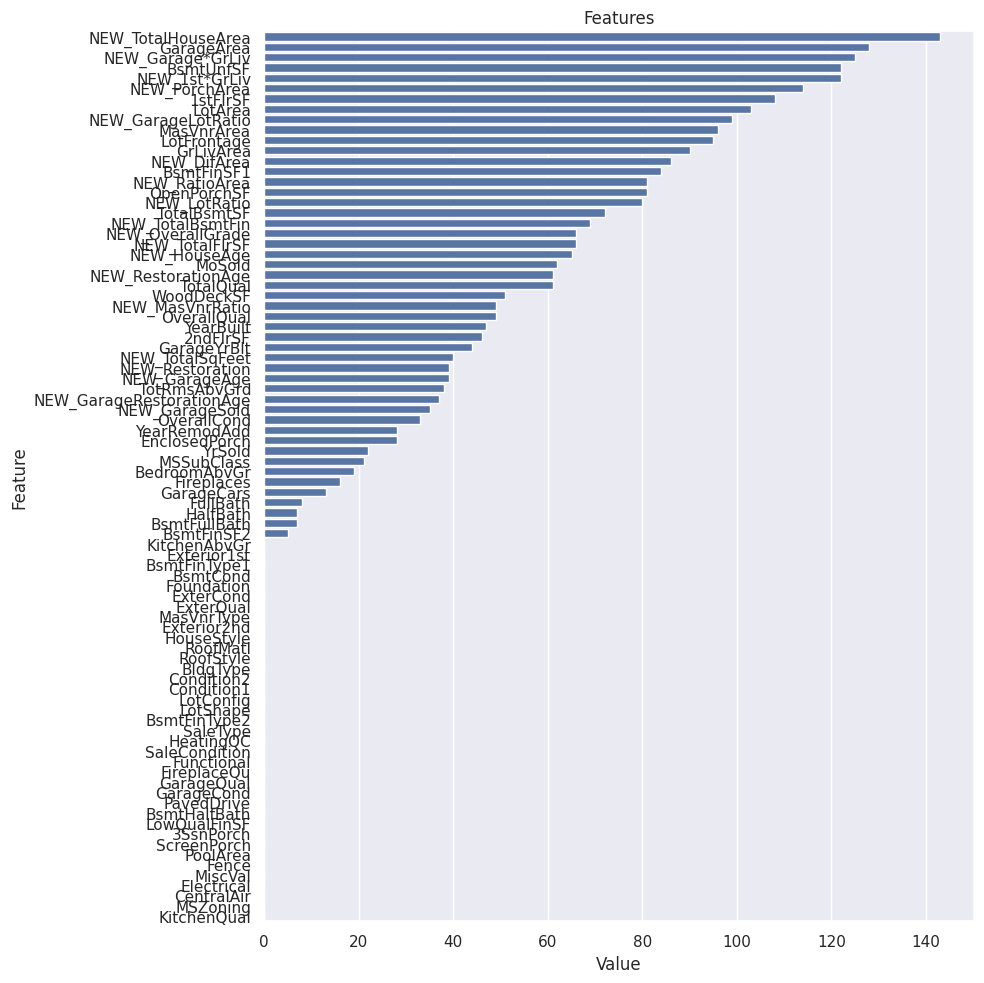

In [98]:
def plot_importance(model, features, num=len(X), save=False):

    feature_imp = pd.DataFrame({"Value": model.feature_importances_, "Feature": features.columns})
    plt.figure(figsize=(10, 10))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False)[0:num])
    plt.title("Features")
    plt.tight_layout()
    plt.show()
    if save:
        plt.savefig("importances.png")

model = LGBMRegressor()
model.fit(X, y)

plot_importance(model, X)